# Analysis of Concept Counts in Climate Documents

This notebook analyzes the distribution and co-occurrence of concepts across different climate-related documents.

In [1]:
import duckdb
from huggingface_hub import snapshot_download
import tqdm as notebook_tqdm

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from pathlib import Path

# Set style for better visualizations
sns.set_theme('notebook')
sns.set_context('notebook')
sns.set_palette('colorblind')


/Users/ajs/Programming/knowledge-graph/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and Prepare Data

In [2]:
reload = True #To stop me accidentally re-loading as that takes a while

First, let's grab our open data from huggingface. See the open data repo for details.
Note that this can take a while as it is a large file. Not sure why, but the creation of the data frame in particular takes a few minutes

In [3]:

REPO_NAME = "ClimatePolicyRadar/all-document-text-data-weekly"
REPO_URL = f"https://huggingface.co/datasets/{REPO_NAME}"
DATA_CACHE_DIR = "../../cache"

REVISION = "main"  # Use this to set a commit hash. Recommended!

snapshot_download(
    repo_id=REPO_NAME,
    repo_type="dataset",
    local_dir=DATA_CACHE_DIR,
    revision=REVISION,
    allow_patterns=["*.parquet"],
)
if reload:
    db = duckdb.connect()

    # Authenticate (needed if loading a private dataset)
    # You'll need to log in using `huggingface-cli login` in your terminal first
    db.execute("CREATE SECRET hf_token (TYPE HUGGINGFACE, PROVIDER credential_chain);")
    print("Authenticated")

    # Create a view called 'open_data'
    db.execute(
        f"CREATE VIEW open_data AS SELECT * FROM read_parquet('{DATA_CACHE_DIR}/*.parquet')"
    )
    print("Open_data view created")

    #TODO: Get a progress bar on this because it takes a while
    #document_id, "document_metadata.collection_title", "document_metadata.corpus_type_name", "document_metadata.corpus_import_id", "document_metadata.family_import_id", "document_metadata.import_id", document_name, "document_metadata.document_title", "text_block.text", "text_block.language", "document_metadata.publication_ts", languages, translated, "document_metadata.geographies"
    doc_data = db.sql(
        """
        SELECT document_id, "document_metadata.document_title", "document_metadata.collection_title", "document_metadata.corpus_type_name","text_block.text", "text_block.language", "document_metadata.publication_ts", languages, "document_metadata.geographies", "document_metadata.slug"
        FROM open_data 
        WHERE "document_id" is not NULL
        """
    ).to_df()

Fetching 40 files: 100%|██████████| 40/40 [08:25<00:00, 12.64s/it]  


Authenticated
Open_data view created


In [4]:
print(f"Number of paragraphs: {len(doc_data)}")
doc_data.head()

Number of paragraphs: 59305543


document_id document_metadata.document_title  \
0  AF.document.002MMUCR.n0000                 Project document   
1  AF.document.002MMUCR.n0000                 Project document   
2  AF.document.002MMUCR.n0001                 Inception report   
3  AF.document.002MMUCR.n0001                 Inception report   
4  AF.document.002MMUCR.n0001                 Inception report   

  document_metadata.collection_title document_metadata.corpus_type_name  \
0                               None                                 AF   
1                               None                                 AF   
2                               None                                 AF   
3                               None                                 AF   
4                               None                                 AF   

          text_block.text text_block.language  \
0                    None                None   
1                    None                None   
2         ADAPTATION FUND                  en   
3  CLAVISQUE MARIS INDIES                  en   
4                   UN DP                  en   

  document_metadata.publication_ts languages document_metadata.geographies  \
0             2011-09-16T00:00:00Z      <NA>                         [MUS]   
1             2011-09-16T00:00:00Z      [en]                         [MUS]   
2             2011-09-16T00:00:00Z      [en]                         [MUS]   
3             2011-09-16T00:00:00Z      [en]                         [MUS]   
4             2011-09-16T00:00:00Z      [en]                         [MUS]   

  document_metadata.slug  
0  project-document_1b5f  
1  project-document_1b5f  
2  inception-report_d20e  
3  inception-report_d20e  
4  inception-report_d20e

In [5]:
# Load concept counts
concept_counts = pd.read_csv('data/out/250325_concept_counts.csv')

## Load document metadata -- this is not updated so prefer the open data above
#doc_data = pd.read_feather('data/processed/combined_dataset.feather')

# Extract document ID from the first column of concept_counts
concept_counts['document_id'] = concept_counts.iloc[:, 0]

# Merge datasets
# (i.e. are there docs where only some paras have a geography)
merged_df = pd.merge(concept_counts, doc_data.drop_duplicates(subset=['document_id']),
                    on='document_id', how='left')

assert len(merged_df) == len(concept_counts), "Data lost in merge? Merged dataframe has a different number of rows than concept counts"

# Get list of concept columns (starting with Q)
concept_cols = [col for col in concept_counts.columns if col.startswith('Q')]

print(f"Number of classified paragraphs: {len(merged_df)}")
print(f"Number of concepts: {len(concept_cols)}")

Number of classified paragraphs: 11811
Number of concepts: 71


In [6]:
#There's a weird thing going on where no info is added for quite a bunch of documents. 
# Could it be that the IDs don't overlap somehow?
no_overlap = (set(concept_counts['document_id']) - set(doc_data['document_id']))

print(len(no_overlap))
print(list(no_overlap)[0:20])

2610
['CCLW.executive.1812.1973_translated_en', 'UNFCCC.party.419.0_translated_en', 'CCLW.executive.11073.6375_translated_en', 'UNFCCC.party.1574.0_translated_en', 'CPR.document.i00000426.n0000_translated_en', 'UNFCCC.party.910.0_translated_en', 'CCLW.document.i00001328.n0000_translated_en', 'CCLW.executive.10371.5015_translated_en', 'CCLW.executive.8232.2023_translated_en', 'CCLW.executive.10307.4977_translated_en', 'UNFCCC.party.995.0_translated_en', 'UNFCCC.party.1218.0_translated_en', 'CCLW.executive.10593.5672_translated_en', 'CCLW.executive.8593.1987_translated_en', 'CCLW.executive.9426.3540_translated_en', 'CCLW.executive.1659.2242_translated_en', 'CCLW.legislative.10900.rtl_235_translated_en', 'CCLW.document.i00001787.n0000_translated_en', 'CCLW.executive.8741.1419_translated_en', 'CCLW.executive.1434.2437_translated_en']


In [7]:
# Concept names starting with a Q are not exactly easy to interpret
# So let's manually define a mapping (Probably better to do this from the concept store but this is quicker for now)
concept_names = {
    'Q1016': 'Sexual minority',
    'Q1167': 'Limited assets',
    'Q1269': 'Tax advantage',
    'Q1273': 'Loan',
    'Q1274': 'Subsidy',
    'Q1275': 'Subsidy removal',
    'Q1276': 'Direct investment',
    'Q1277': 'Fees and charges',
    'Q1278': 'Insurance',
    'Q1279': 'Feed-in tariff',
    'Q1280': 'Tradable permit',
    'Q1281': 'Standard setting',
    'Q1282': 'Spatial planning',
    'Q1284': 'Due diligence',
    'Q1285': 'Ban',
    'Q1286': 'Early warning system',
    'Q1343': 'Climate finance', 
    'Q1344': 'Mitigation finance',
    'Q1345': 'Adaptation finance',
    'Q1346': 'Loss and damage finance',
    'Q1362': 'Climate fund',
    'Q1368': 'Export credit agency',
    'Q1369': 'Central bank',
    'Q1370': 'State-owned enterprise', #Wow, long list of keywords!
    'Q1371': 'State-owned financial inst.',
    'Q1651': 'Target',
    'Q1652': 'Emissions target',
    'Q1653': 'Net-zero target',
    'Q218': 'Greenhouse gas',
    'Q221': 'GHG emissions',
    'Q223': 'Carbon dioxide',
    'Q226': 'Methane',
    'Q374': 'Extreme weather',
    'Q404': 'Terrestrial risk',
    'Q412': 'Air pollution',
    'Q639': 'Oil',
    'Q650': 'Fossil gas',
    'Q661': 'Coal',
    'Q676': 'Marginalized ethnicity',
    'Q684': 'Indigenous People',
    'Q690': 'Person w health condition',
    'Q695': 'Youth',
    'Q701': 'People on the move',
    'Q704': 'Women and minority genders',
    'Q708': 'Elderly',
    'Q715': 'Tax',
    'Q757': 'Informal sector',
    'Q761': 'Manufacturing sector',
    'Q762': 'Energy supply sector',  
    'Q763': 'Environmental mgmt sector',
    'Q764': 'Construction sector',
    'Q765': 'Trade sector',
    'Q766': 'Transportation sector',
    'Q767': 'Hospitality sector',
    'Q769': 'ICT sector',
    'Q774': 'Education sector',
    'Q775': 'Public sector',
    'Q777': 'Prof. services sector',
    'Q778': 'Real estate sector',
    'Q779': 'Finance and insurance sec.',
    'Q786': 'Agriculture sector',
    'Q787': 'Forestry sector',
    'Q788': 'Fishing sector',
    'Q818': 'Water management sector',
    'Q857': 'Healthcare sector',
    'Q954': 'Technological impact',
    'Q955': 'Chemical impact',
    'Q956': 'Societal impact',
    'Q973': 'Slow onset event',
    'Q983': 'Cryosphere risk',
    'Q986': 'Geohazard' 
}

merged_df.rename(columns=concept_names, inplace=True)
concept_counts.rename(columns=concept_names, inplace=True)
concept_cols = list(concept_names.values())

In [8]:
concept_categories = {
    'Impacted groups': [
        'Sexual minority',
        'Limited assets',
        'Marginalized ethnicity',
        'Indigenous People',
        'Person w health condition',
        'Youth',
        'People on the move',
        'Women and minority genders',
        'Elderly',                  
    ],

    "Climate finance": [
        "Climate finance",
        "Mitigation finance",
        "Adaptation finance",
        "Loss and damage finance",
    ],

    "Finance actors": [
        "Climate fund", #This should be a double parent category with "Climate finance" but that's a pain to do here
        "Export credit agency",
        "Central bank",
        "State-owned enterprise",
        "State-owned financial inst.",
    ],

    "Climate impacts": [
        'Extreme weather',
        'Terrestrial risk',
        'Air pollution',
        'Technological impact',
        'Chemical impact',
        'Societal impact',
        'Slow onset event',
        'Cryosphere risk',
        'Geohazard' 
    ],

    "Sectors": [
        "Agriculture sector",
        "Forestry sector",
        "Fishing sector",
        "Water management sector",
        "Healthcare sector",
        "Manufacturing sector",
        "Energy supply sector",
        "Environmental mgmt sector",
        "Construction sector",
        "Prof. services sector",
        "Real estate sector",
        "Finance and insurance sec.",
        "Trade sector",
        "Transportation sector",
        "Hospitality sector",
        "ICT sector",
        "Education sector",
        "Informal sector",
        "Public sector"
    ],
    "Greenhouse gas": [
        "Greenhouse gas",
        "GHG emissions",
        "Carbon dioxide",
        "Methane",
    ],

    "Fossil fuels": [
        'Oil',
        'Fossil gas',
        'Coal',
    ],

    "Targets": [ #Strictly speaking, also a policy instrument 
        "Target",
        "Emissions target",
        "Net-zero target",
    ],

    "Policy instruments": [ 
        'Feed-in tariff',
        'Tradable permit',
        'Standard setting',
        'Spatial planning',
        'Due diligence',
        'Ban',
        'Early warning system',
        "Tax",
        'Tax advantage',
        'Loan',
        'Subsidy',
        'Subsidy removal',
        'Direct investment',
        'Fees and charges',
        'Insurance',

    ],
}

In [9]:
#Let's check that I have all of them
# Flatten all concepts in categories
categorized_concepts = []
for category, concepts in concept_categories.items():
    categorized_concepts.extend(concepts)

# Find missing concepts
missing_concepts = [col for col in concept_cols if col not in categorized_concepts]
if len(missing_concepts) > 0:
    print(f"Missing concepts: {missing_concepts}")
else:
    print("All concepts are accounted for")

# Find misspelled concepts
misspelled_concepts = [col for col in categorized_concepts if col not in concept_cols]
if len(misspelled_concepts) > 0:
    print(f"Misspelled concepts: {misspelled_concepts}")
else:
    print("All concepts are spelled correctly")


All concepts are accounted for
All concepts are spelled correctly


## Geographic Distribution of Concepts

In [10]:
# A single document can have multiple geographies
# Let's create an exploded version of the data for the geographic analysis
merged_df_geographies = merged_df.copy()
merged_df_geographies = merged_df_geographies.explode("document_metadata.geographies")
print(len(merged_df_geographies))

14961


In [12]:
def load_world_geometries():
    """
    Get world geometries in Eckert IV projection.

    Drop Antarctica and Seven seas (open ocean) geometries to make the map look nicer.
    """
    world = gpd.read_file(
        r"/Users/ajs/Programming/open-data/open-data/data/earth_vectors/ne_50m_admin_0_countries.shp"
        #Path(__file__).parent / "../data/earth_vectors/ne_50m_admin_0_countries.shp"
    )
    world = world.to_crs(
        "+proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"
    )

    world = world[~world["ADMIN"].isin(["Antarctica", "Seven seas (open ocean)"])]

    # fix for bug https://github.com/geopandas/geopandas/issues/1041
    world.loc[world['NAME'] == 'France', 'ISO_A3'] = 'FRA'
    world.loc[world['NAME'] == 'Norway', 'ISO_A3'] = 'NOR'
    world.loc[world['NAME'] == 'N. Cyprus', 'ISO_A3'] = 'CYP'
    world.loc[world['NAME'] == 'Somaliland', 'ISO_A3'] = 'SOM'
    world.loc[world['NAME'] == 'Kosovo', 'ISO_A3'] = 'RKS'
    #Can also use ISO_A3_EH but then Somaliland (and maybe others?) are still a problem

    return world
world = load_world_geometries()
world.head()

featurecla  scalerank  LABELRANK SOVEREIGNT SOV_A3  ADM0_DIF  LEVEL  \
0  Admin-0 country          1          3   Zimbabwe    ZWE         0      2   
1  Admin-0 country          1          3     Zambia    ZMB         0      2   
2  Admin-0 country          1          3      Yemen    YEM         0      2   
3  Admin-0 country          3          2    Vietnam    VNM         0      2   
4  Admin-0 country          5          3  Venezuela    VEN         0      2   

                TYPE TLC      ADMIN  ... FCLASS_TR  FCLASS_ID FCLASS_PL  \
0  Sovereign country   1   Zimbabwe  ...      None       None      None   
1  Sovereign country   1     Zambia  ...      None       None      None   
2  Sovereign country   1      Yemen  ...      None       None      None   
3  Sovereign country   1    Vietnam  ...      None       None      None   
4  Sovereign country   1  Venezuela  ...      None       None      None   

  FCLASS_GR  FCLASS_IT FCLASS_NL FCLASS_SE  FCLASS_BD FCLASS_UA  \
0      None       None      None      None       None      None   
1      None       None      None      None       None      None   
2      None       None      None      None       None      None   
3      None       None      None      None       None      None   
4      None       None      None      None       None      None   

                                            geometry  
0  POLYGON ((2851702.96 -2907531.613, 2843897.915...  
1  POLYGON ((2815004.412 -2046626.729, 2801535.76...  
2  MULTIPOLYGON (((4906470.051 2175967.039, 48616...  
3  MULTIPOLYGON (((9718609.874 1365203.419, 97210...  
4  MULTIPOLYGON (((-5688622.131 1201552.537, -570...  

[5 rows x 169 columns]

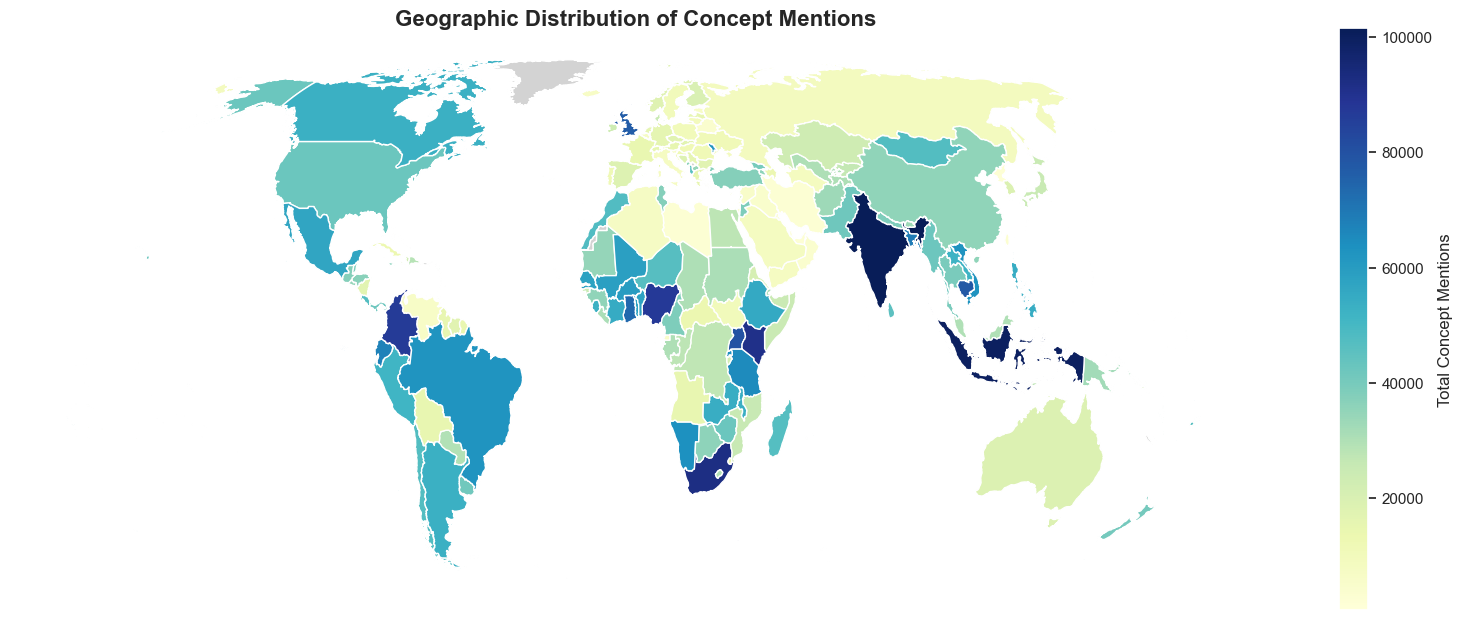

In [13]:
# Calculate total concept mentions per country
country_concepts = merged_df_geographies.groupby('document_metadata.geographies'
                                                 )[concept_cols].sum().sum(axis=1).reset_index()
country_concepts.columns = ['ISO_A3', 'total_concepts']

# Merge with world map data
world_concepts = world.merge(country_concepts, on='ISO_A3', how='left')

# Plot
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
world_concepts.plot(column='total_concepts', 
                   ax=ax,
                   legend=True,
                   legend_kwds={'label': 'Total Concept Mentions',
                                'shrink': 0.5},
                   missing_kwds={'color': 'lightgrey',},
                   cmap='YlGnBu',
                   )
ax.set_title('Geographic Distribution of Concept Mentions', size=16, weight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

In [14]:
world_concepts.sort_values(by='total_concepts', ascending=False)[['ISO_A3', 'NAME', 'total_concepts']].head(10)


ISO_A3            NAME  total_concepts
144    IND           India        101548.0
143    IDN       Indonesia         99957.0
56     ZAF    South Africa         92283.0
132    KEN           Kenya         90983.0
90     NGA         Nigeria         87134.0
194    COL        Colombia         86938.0
34     UGA          Uganda         79619.0
204    KHM        Cambodia         77939.0
31     GBR  United Kingdom         76898.0
155    GHA           Ghana         73668.0

Massively high numbers in a few countries in the Global South! That's good news, but given what we know about the distribution of polices, this is mostly due to the MCF documents. 
Also high number in the UK relative to the rest of Europe. That might just be because LSE has a bit of a UK bias, but could be worth looking into


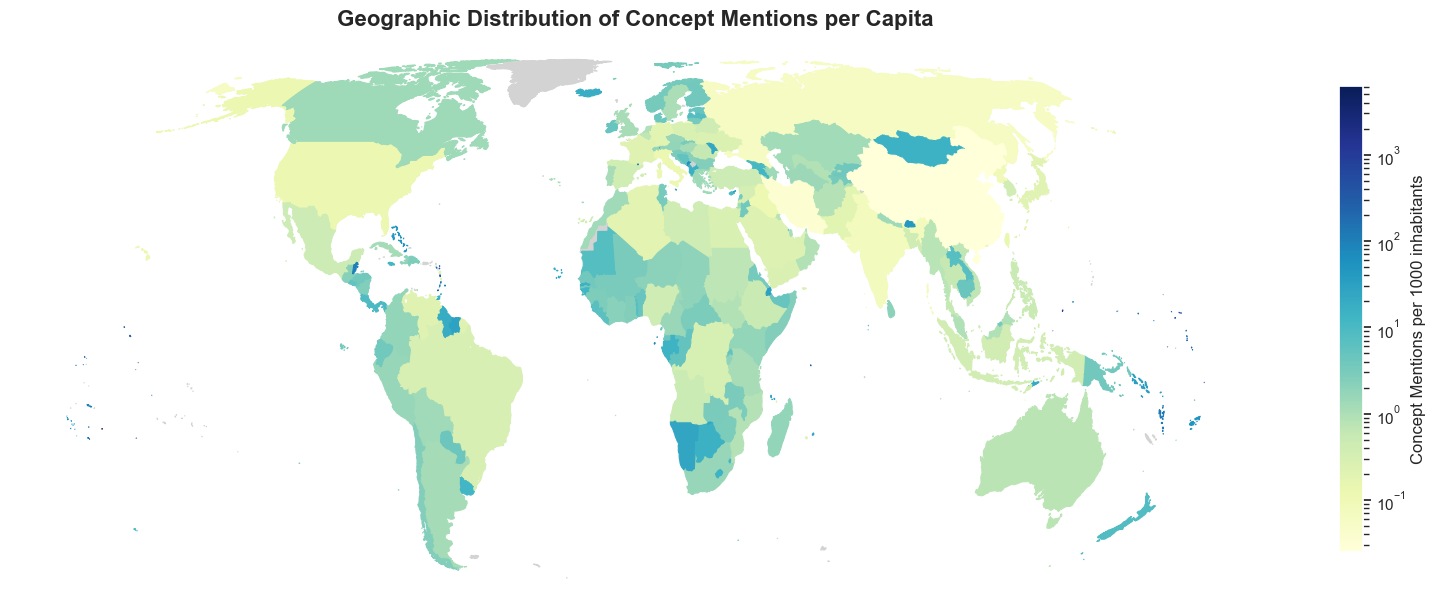

In [15]:
#Plot the same but normalized by country population
world_concepts['normalized_concepts'] = world_concepts['total_concepts'] / world_concepts['POP_EST']*1000
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
world_concepts.plot(column='normalized_concepts', 
                   ax=ax,
                   legend=True,
                   cmap='YlGnBu',
                   edgecolor = 'face', #Makes especially SIDS a bit more visible
                   linewidth = 0.8, #though setting this too high makes it a bit blobby
                   norm=colors.LogNorm(),
                   legend_kwds={'label': 'Concept Mentions per 1000 inhabitants',
                                'shrink': 0.4,
                                },
                   missing_kwds={'color': 'lightgrey'}
                   )
ax.set_title('Geographic Distribution of Concept Mentions per Capita', size=16, weight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

In [16]:
#Let's sort by the normalized values and print the top 10 geographies
world_concepts.sort_values(by='normalized_concepts', ascending=False)[['ISO_A3', 'NAME', 'normalized_concepts']].head(10)


ISO_A3               NAME  normalized_concepts
94     NIU               Niue          6239.506173
240    TUV             Tuvalu          1737.764039
100    NRU              Nauru          1027.978698
95     COK           Cook Is.           968.325792
85     PLW              Palau           701.743669
10     MHL       Marshall Is.           405.725366
179    DMA           Dominica           368.914327
232    ATG  Antigua and Barb.           348.277353
64     SYC         Seychelles           294.299616
153    GRD            Grenada           270.421328

So SIDS are skewing this result quite a bit, but it looks like we have pretty good coverage overall


In [17]:
#TODO further investigate documents with no geography; check UK too

## Top Concepts Analysis

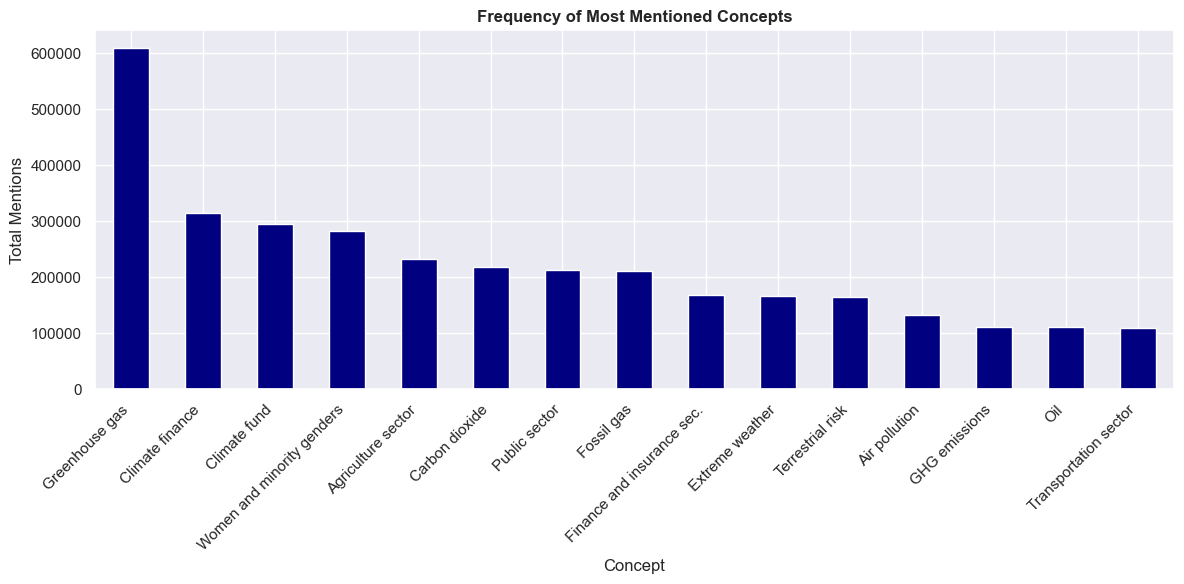

In [18]:
# Calculate total mentions for each concept
concept_totals = concept_counts[concept_cols].sum().sort_values(ascending=False)

# Plot top 15 concepts
concept_totals.head(15).plot(kind='bar', color='navy', figsize=(12, 6))
plt.title('Frequency of Most Mentioned Concepts', weight='bold')
plt.xlabel('Concept')
plt.ylabel('Total Mentions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Overall, pretty mitigation focussed with finance too. There is a lot of GHG and some financial reporting in our database, so that's perhaps not surprising. 

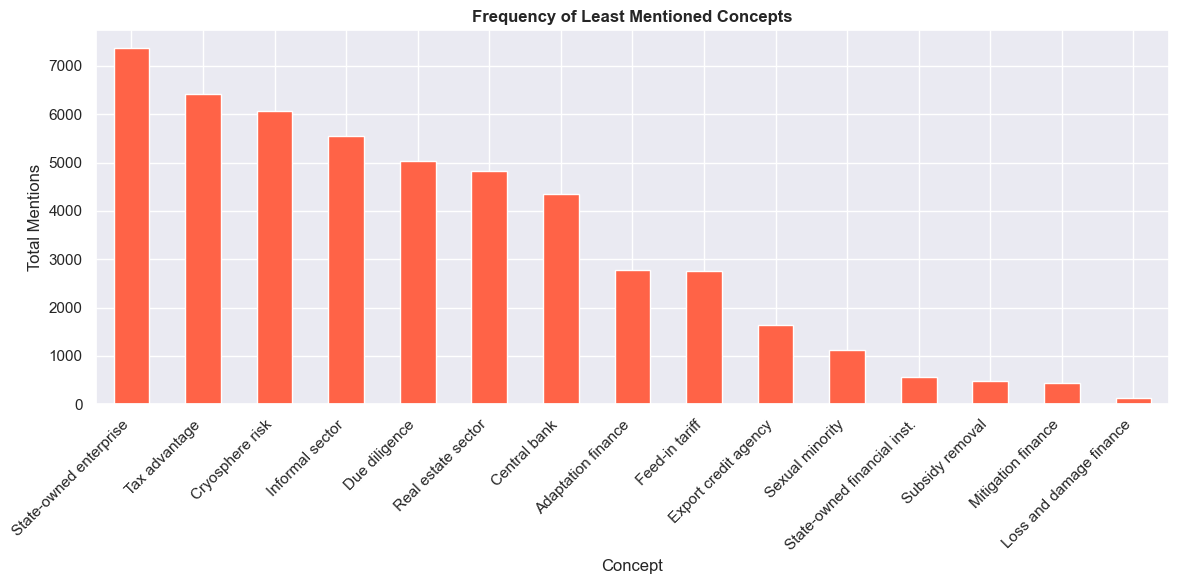

In [19]:
#Same but bottom 15
concept_totals.tail(15).plot(kind='bar', color='tomato', figsize=(12, 6))
plt.title('Frequency of Least Mentioned Concepts', weight='bold')
plt.xlabel('Concept')
plt.ylabel('Total Mentions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#TODO: investigate why mitigation finance is so infrequent, also relative to adaptation

## Regional Analysis

In [20]:
#Lets merge the world info onto the merged_df
merged_df_geographies.rename(columns={'document_metadata.geographies': 'ISO_A3'}, inplace=True)
merged_df_geographies = merged_df_geographies.merge(world[['ISO_A3',
                                    'POP_EST',
                                    'GDP_MD',
                                    'ECONOMY',
                                    'INCOME_GRP',
                                    'REGION_UN',
                                    'SUBREGION',
                                    'REGION_WB'
                                    ]], 
                            on='ISO_A3', how='left')



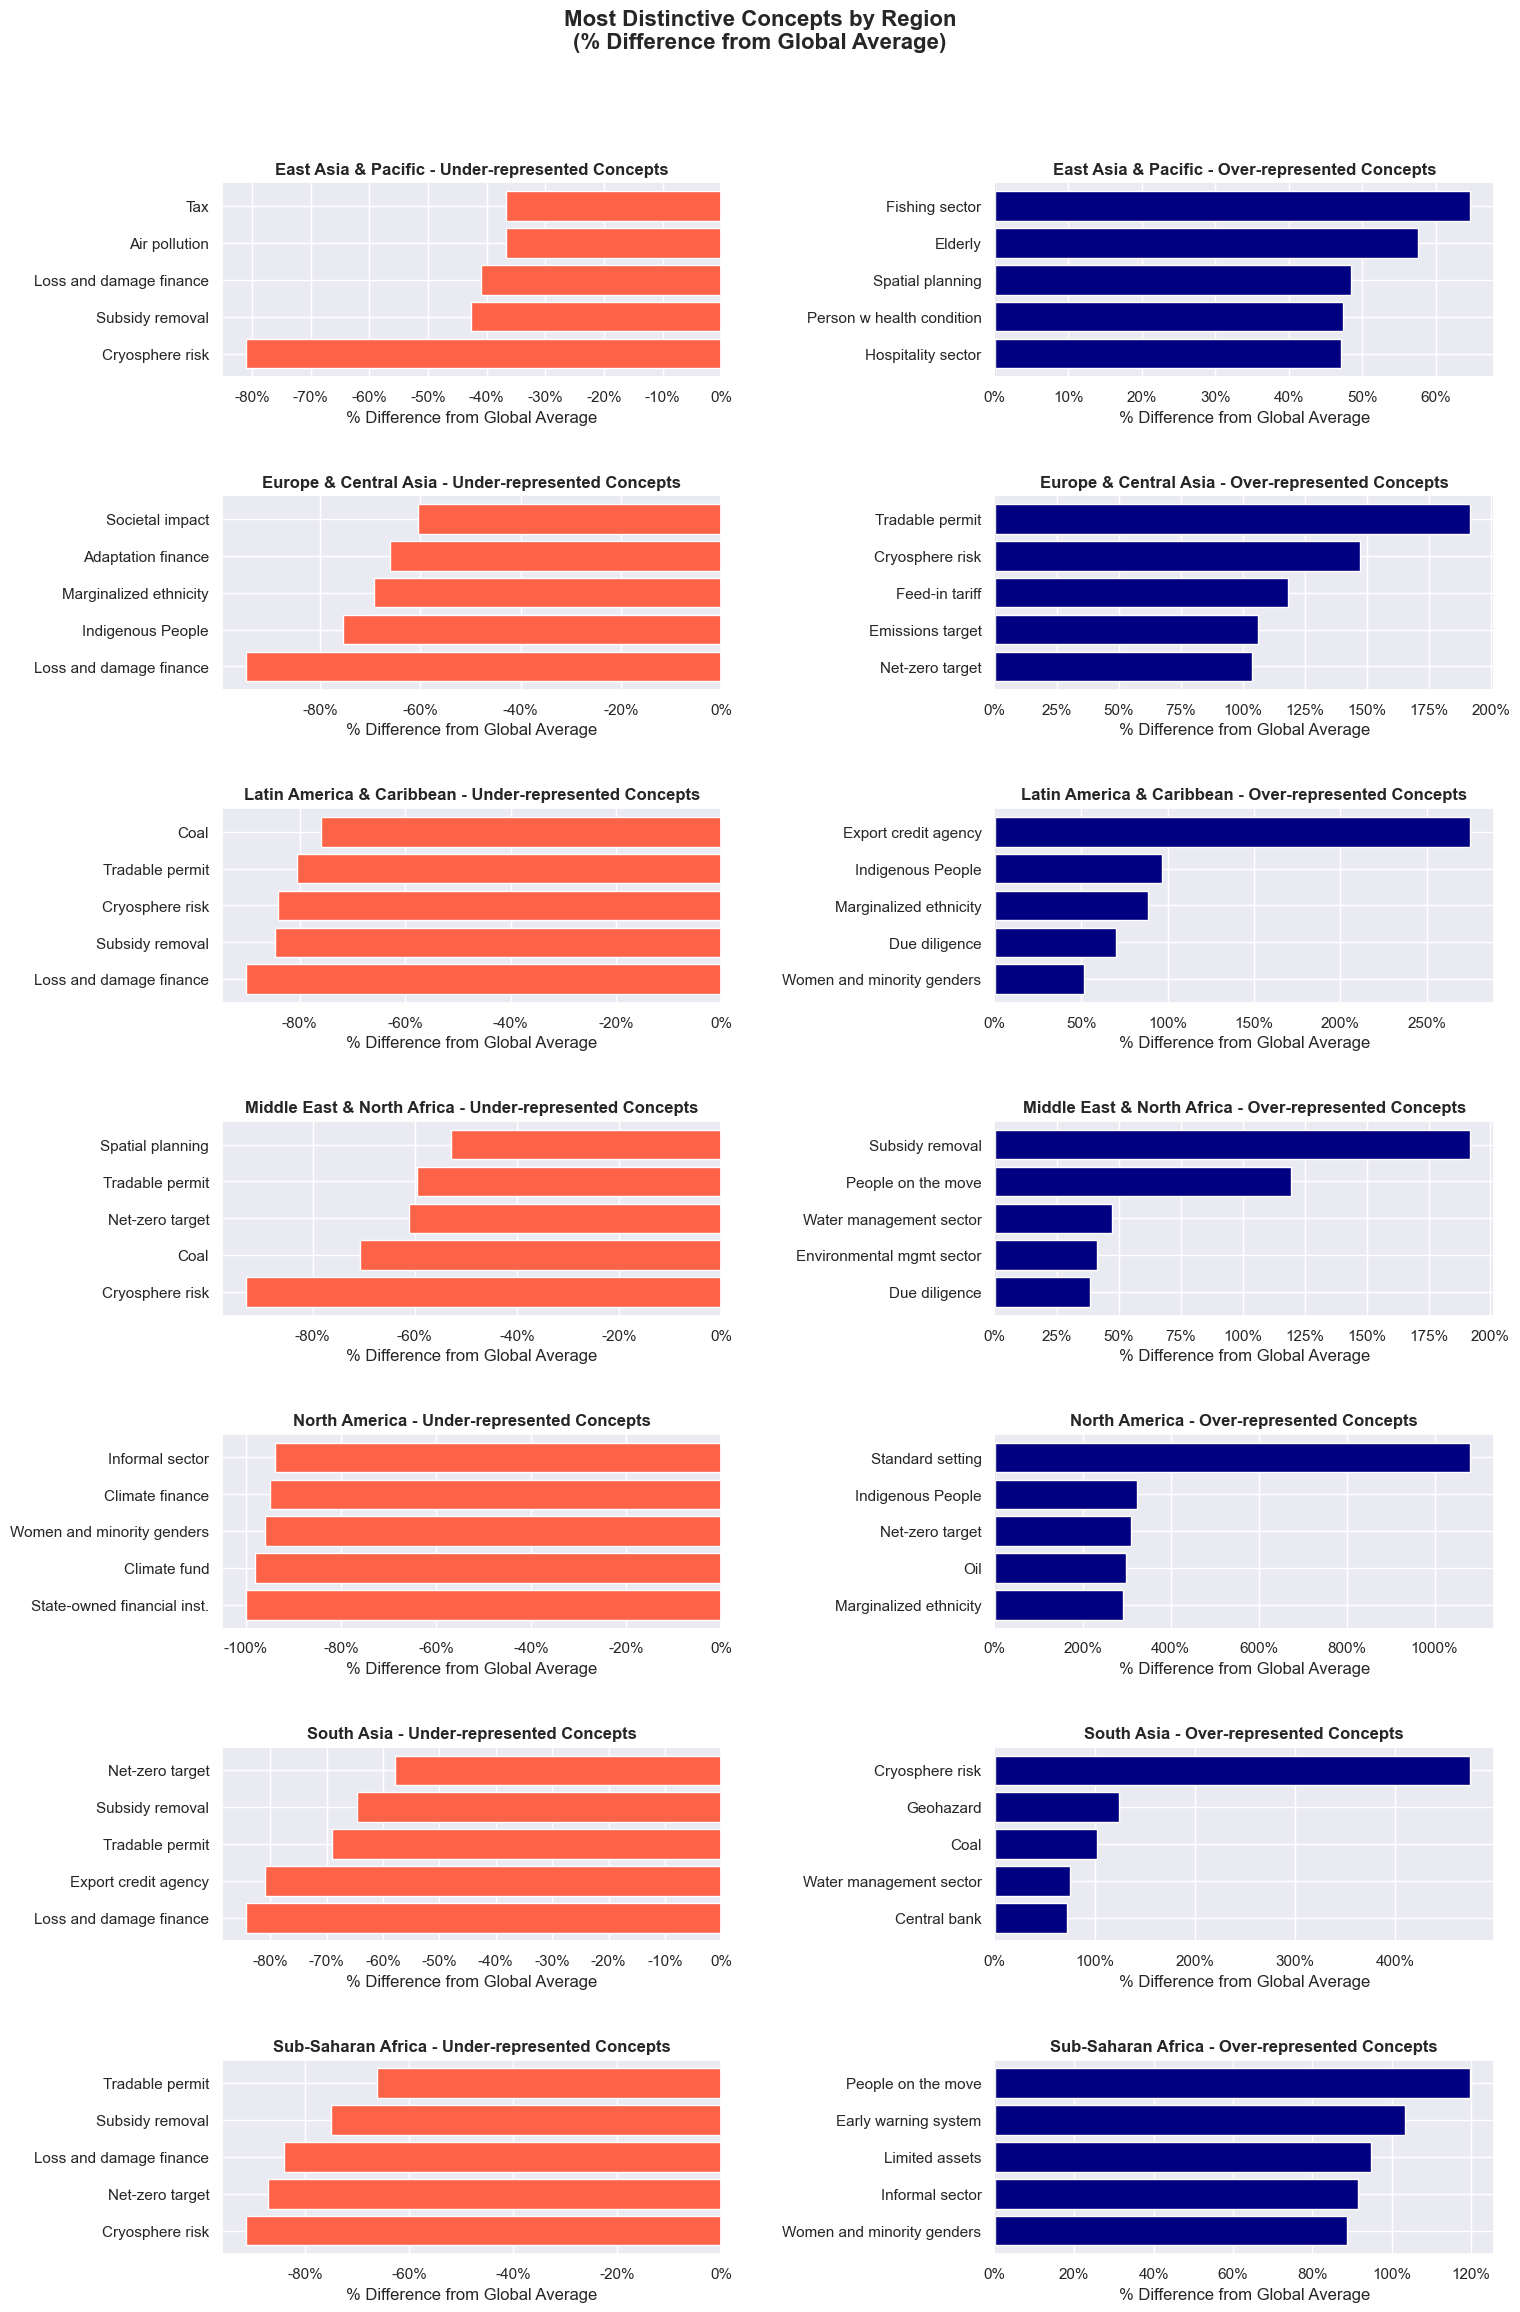

In [21]:
def plot_region_concepts(merged_df, concept_cols, region_col='REGION_WB', print_values=False,
                         title='Most Distinctive Concepts by Region\n(% Difference from Global Average)',
                         custom_region_order = False,
                         n=5):
    """
    Plot the most distinctive concepts by region (or, in practice, any grouping) compared to global average.
    
    Parameters:
    -----------
    merged_df : pandas.DataFrame
        DataFrame containing concept columns and region column
    concept_cols : list
        List of column names containing concept counts
    region_col : str, default='REGION_WB'
        Column name containing region information
    print_values : bool, default=False
        Whether to print detailed statistics
    title : str, default='Most Distinctive Concepts by Region\n(% Difference from Global Average)'
        Title for the plot
    n : int, default=5
        Number of top/bottom concepts to show for each region
    """
    # Calculate global average concept mentions
    global_averages = merged_df[concept_cols].mean()

    # Calculate regional averages
    region_concepts = merged_df.groupby(region_col)[concept_cols].mean()

    # Calculate relative difference from global average
    relative_diff = (region_concepts - global_averages) / global_averages

    # Create subplots for each region
    n_regions = len(region_concepts.index)
    fig, axes = plt.subplots(n_regions, 2, figsize=(16, (n/1.5)*n_regions))
    fig.suptitle(title, y=1.004, fontsize=16, weight='bold')

    if not custom_region_order:
        region_order = region_concepts.index
    else:
        region_order = custom_region_order

    for idx, region in enumerate(region_order):
        region_diffs = relative_diff.loc[region].sort_values()

        #Calculate nr of docs per region to mention in the plot title
        nr_docs = len(merged_df[merged_df[region_col] == region])

        # Under-represented concepts (left plot)
        bottom_n = region_diffs.head(n)
        axes[idx, 0].barh(bottom_n.index, bottom_n.values, color='tomato')
        axes[idx, 0].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        axes[idx, 0].set_title(f'{region} - Under-represented Concepts', weight='bold')
        axes[idx, 0].set_xlabel('% Difference from Global Average')
        # Format x-axis as percentage
        axes[idx, 0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
        
        
        # Over-represented concepts (right plot)
        top_n = region_diffs.tail(n)
        axes[idx, 1].barh(top_n.index, top_n.values, color='navy')
        axes[idx, 1].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        axes[idx, 1].set_title(f'{region} - Over-represented Concepts', weight='bold')
        axes[idx, 1].set_xlabel('% Difference from Global Average')
        # Format x-axis as percentage
        axes[idx, 1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

    plt.tight_layout(pad=3)
    plt.show()
    
    if print_values:
        # Print actual values for reference
        print("\nDetailed Statistics:")
        for region in region_concepts.index:
            print(f"\n{region}:")
            region_diffs = relative_diff.loc[region].sort_values()
            
            print("\nMost Under-represented:")
            for concept in region_diffs.head(5).index:
                regional_avg = region_concepts.loc[region, concept]
                global_avg = global_averages[concept]
                diff_pct = region_diffs[concept]
                print(f"{concept}:")
                print(f"  Regional average: {regional_avg:.3f}")
                print(f"  Global average:  {global_avg:.3f}")
                print(f"  Difference:      {diff_pct:.1%}")
            
            print("\nMost Over-represented:")
            for concept in region_diffs.tail(5).index:
                regional_avg = region_concepts.loc[region, concept]
                global_avg = global_averages[concept]
                diff_pct = region_diffs[concept]
                print(f"{concept}:")
                print(f"  Regional average: {regional_avg:.3f}")
                print(f"  Global average:  {global_avg:.3f}")
                print(f"  Difference:      {diff_pct:.1%}")

    return(fig, axes)

fig, axes = plot_region_concepts(merged_df_geographies, concept_cols)

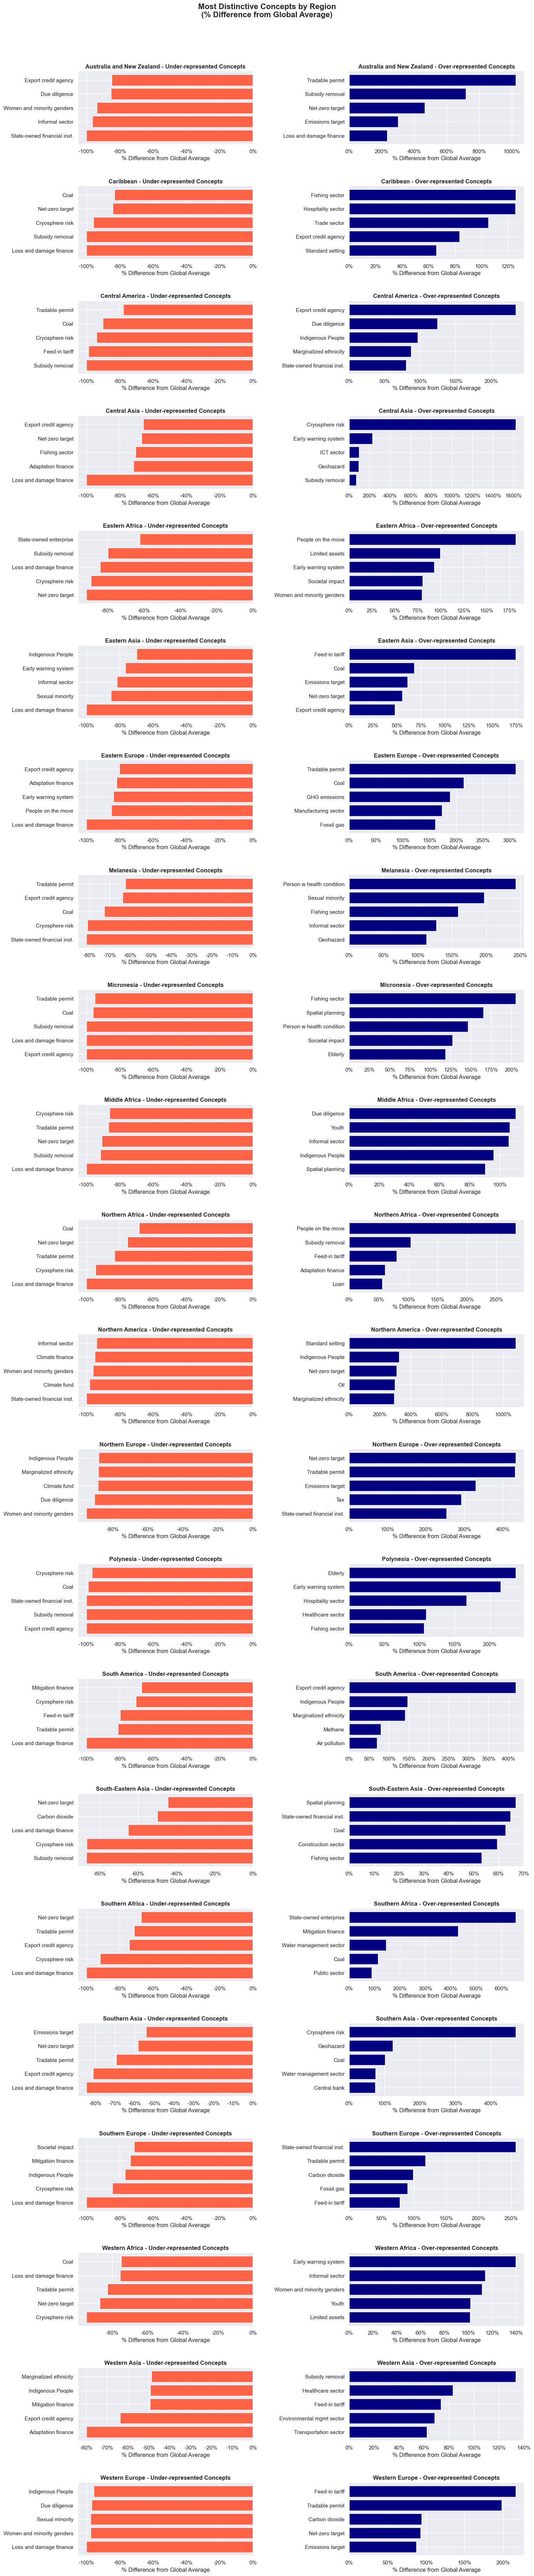

In [22]:
#Is it useful to slice this even thinner?
fig, axes = plot_region_concepts(merged_df_geographies, concept_cols, region_col='SUBREGION')
#Somewhat interesting, but not hugely useful -- pretty sensitive to low-frequency concepts

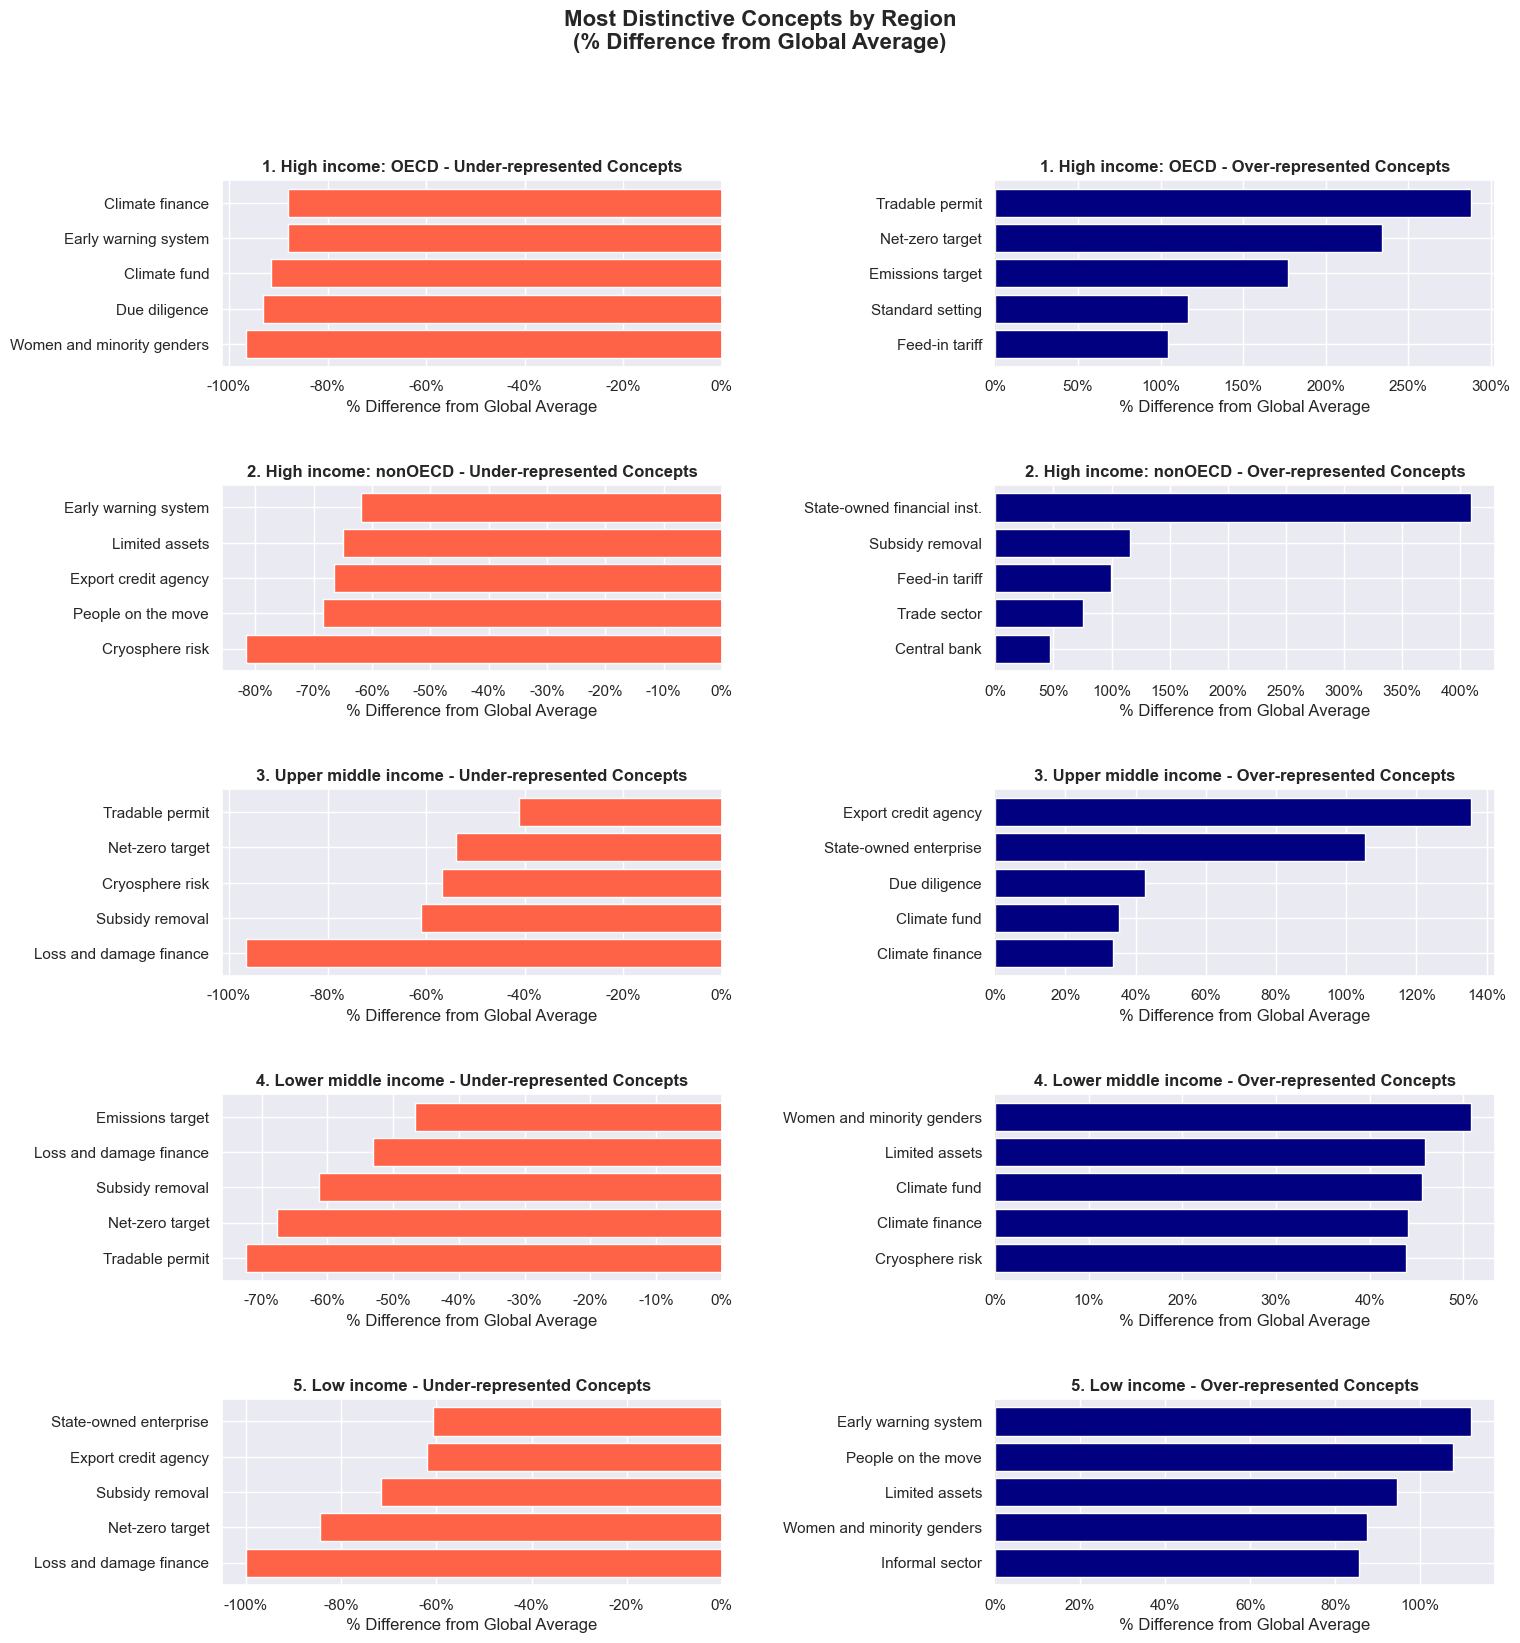

In [23]:
#Then let's try the income groups
fig, axes = plot_region_concepts(merged_df_geographies, concept_cols, region_col='INCOME_GRP')

In [24]:
#Looks good but I don't like the default OECD/non-OECD split, nor the numbers
income_mappers = {
    '1. High income: OECD': 'High income',
    '2. High income: nonOECD': 'High income',
    '3. Upper middle income': 'Upper middle income',
    '4. Lower middle income': 'Lower middle income',
    '5. Low income': 'Low income'
}
# Create new column with mapped income groups
merged_df_geographies['income_level'] = merged_df_geographies['INCOME_GRP'].map(income_mappers)

# Verify the mapping worked
print("Unique values in new income_level column:")
print(merged_df_geographies['income_level'].value_counts())


Unique values in new income_level column:
income_level
Lower middle income    3423
Upper middle income    3104
Low income             2548
High income            1981
Name: count, dtype: int64


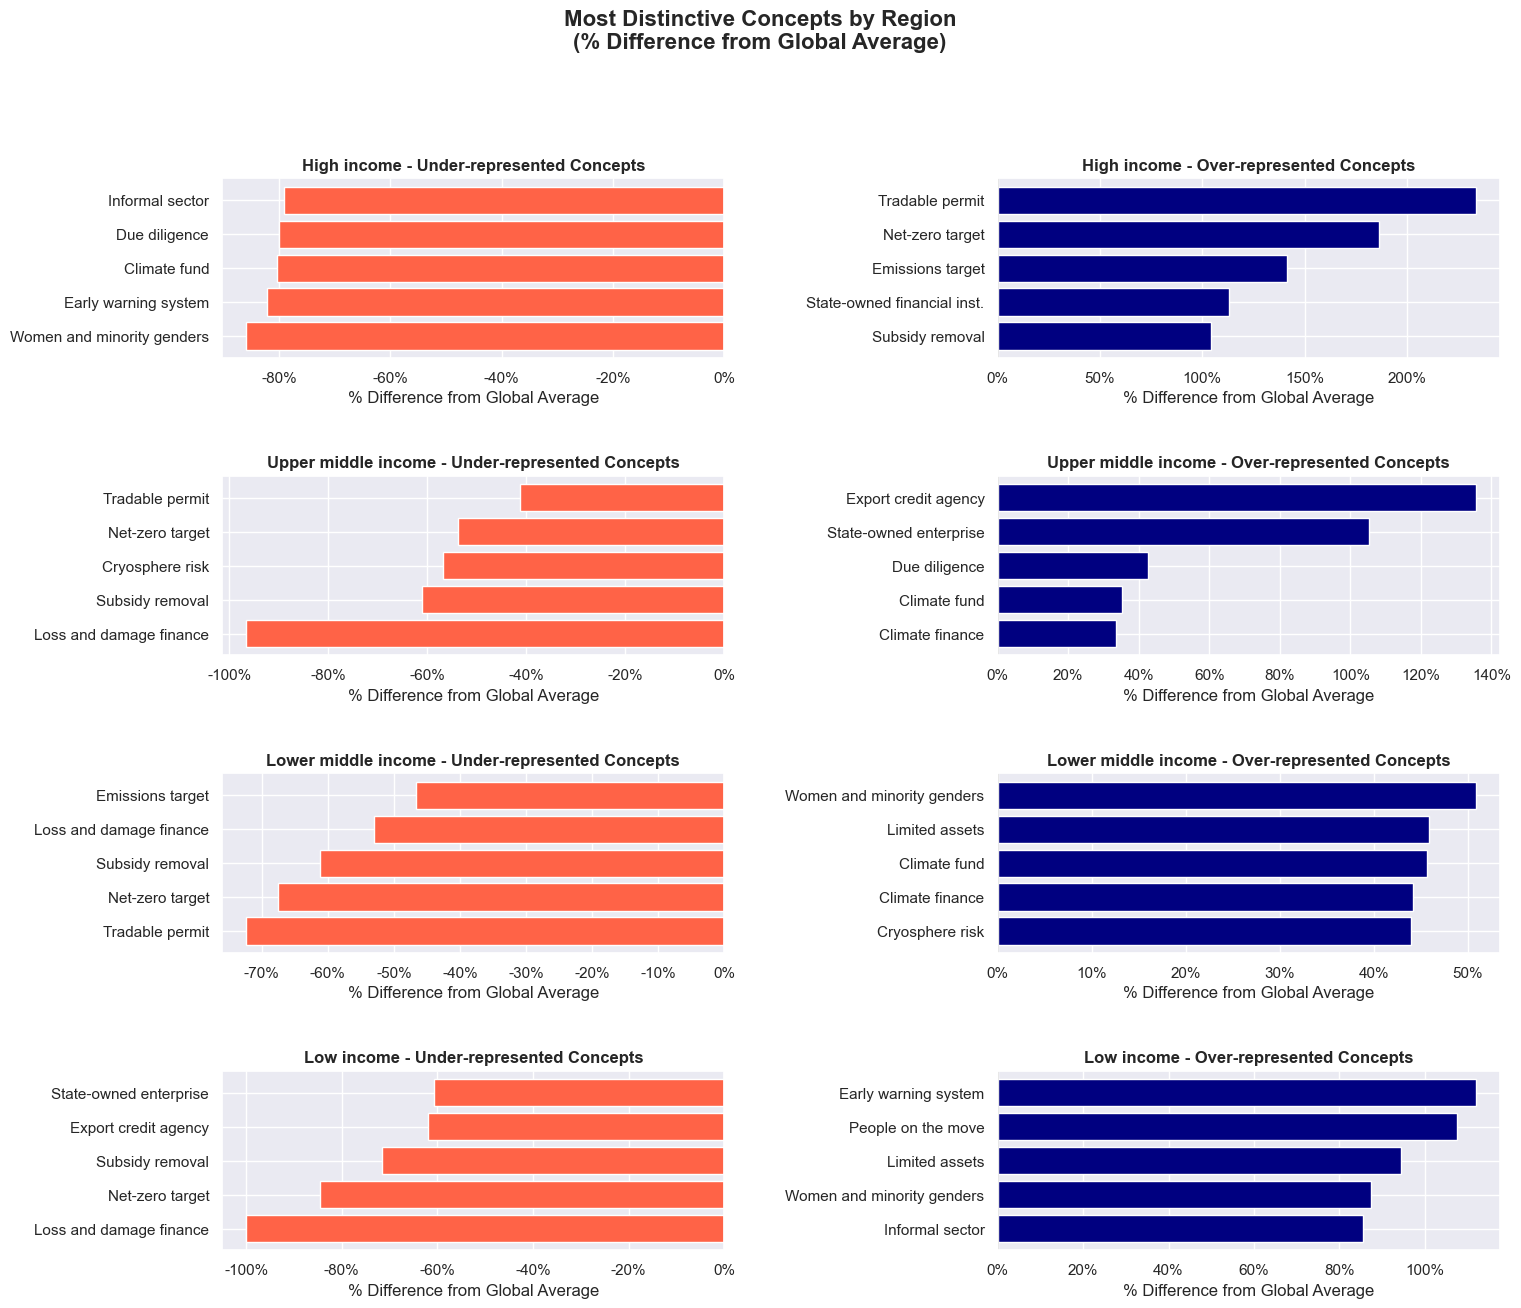

In [25]:
fig, axes = plot_region_concepts(merged_df_geographies, concept_cols, region_col='income_level',
                                 custom_region_order= ['High income', 'Upper middle income', 'Lower middle income' , 'Low income'])

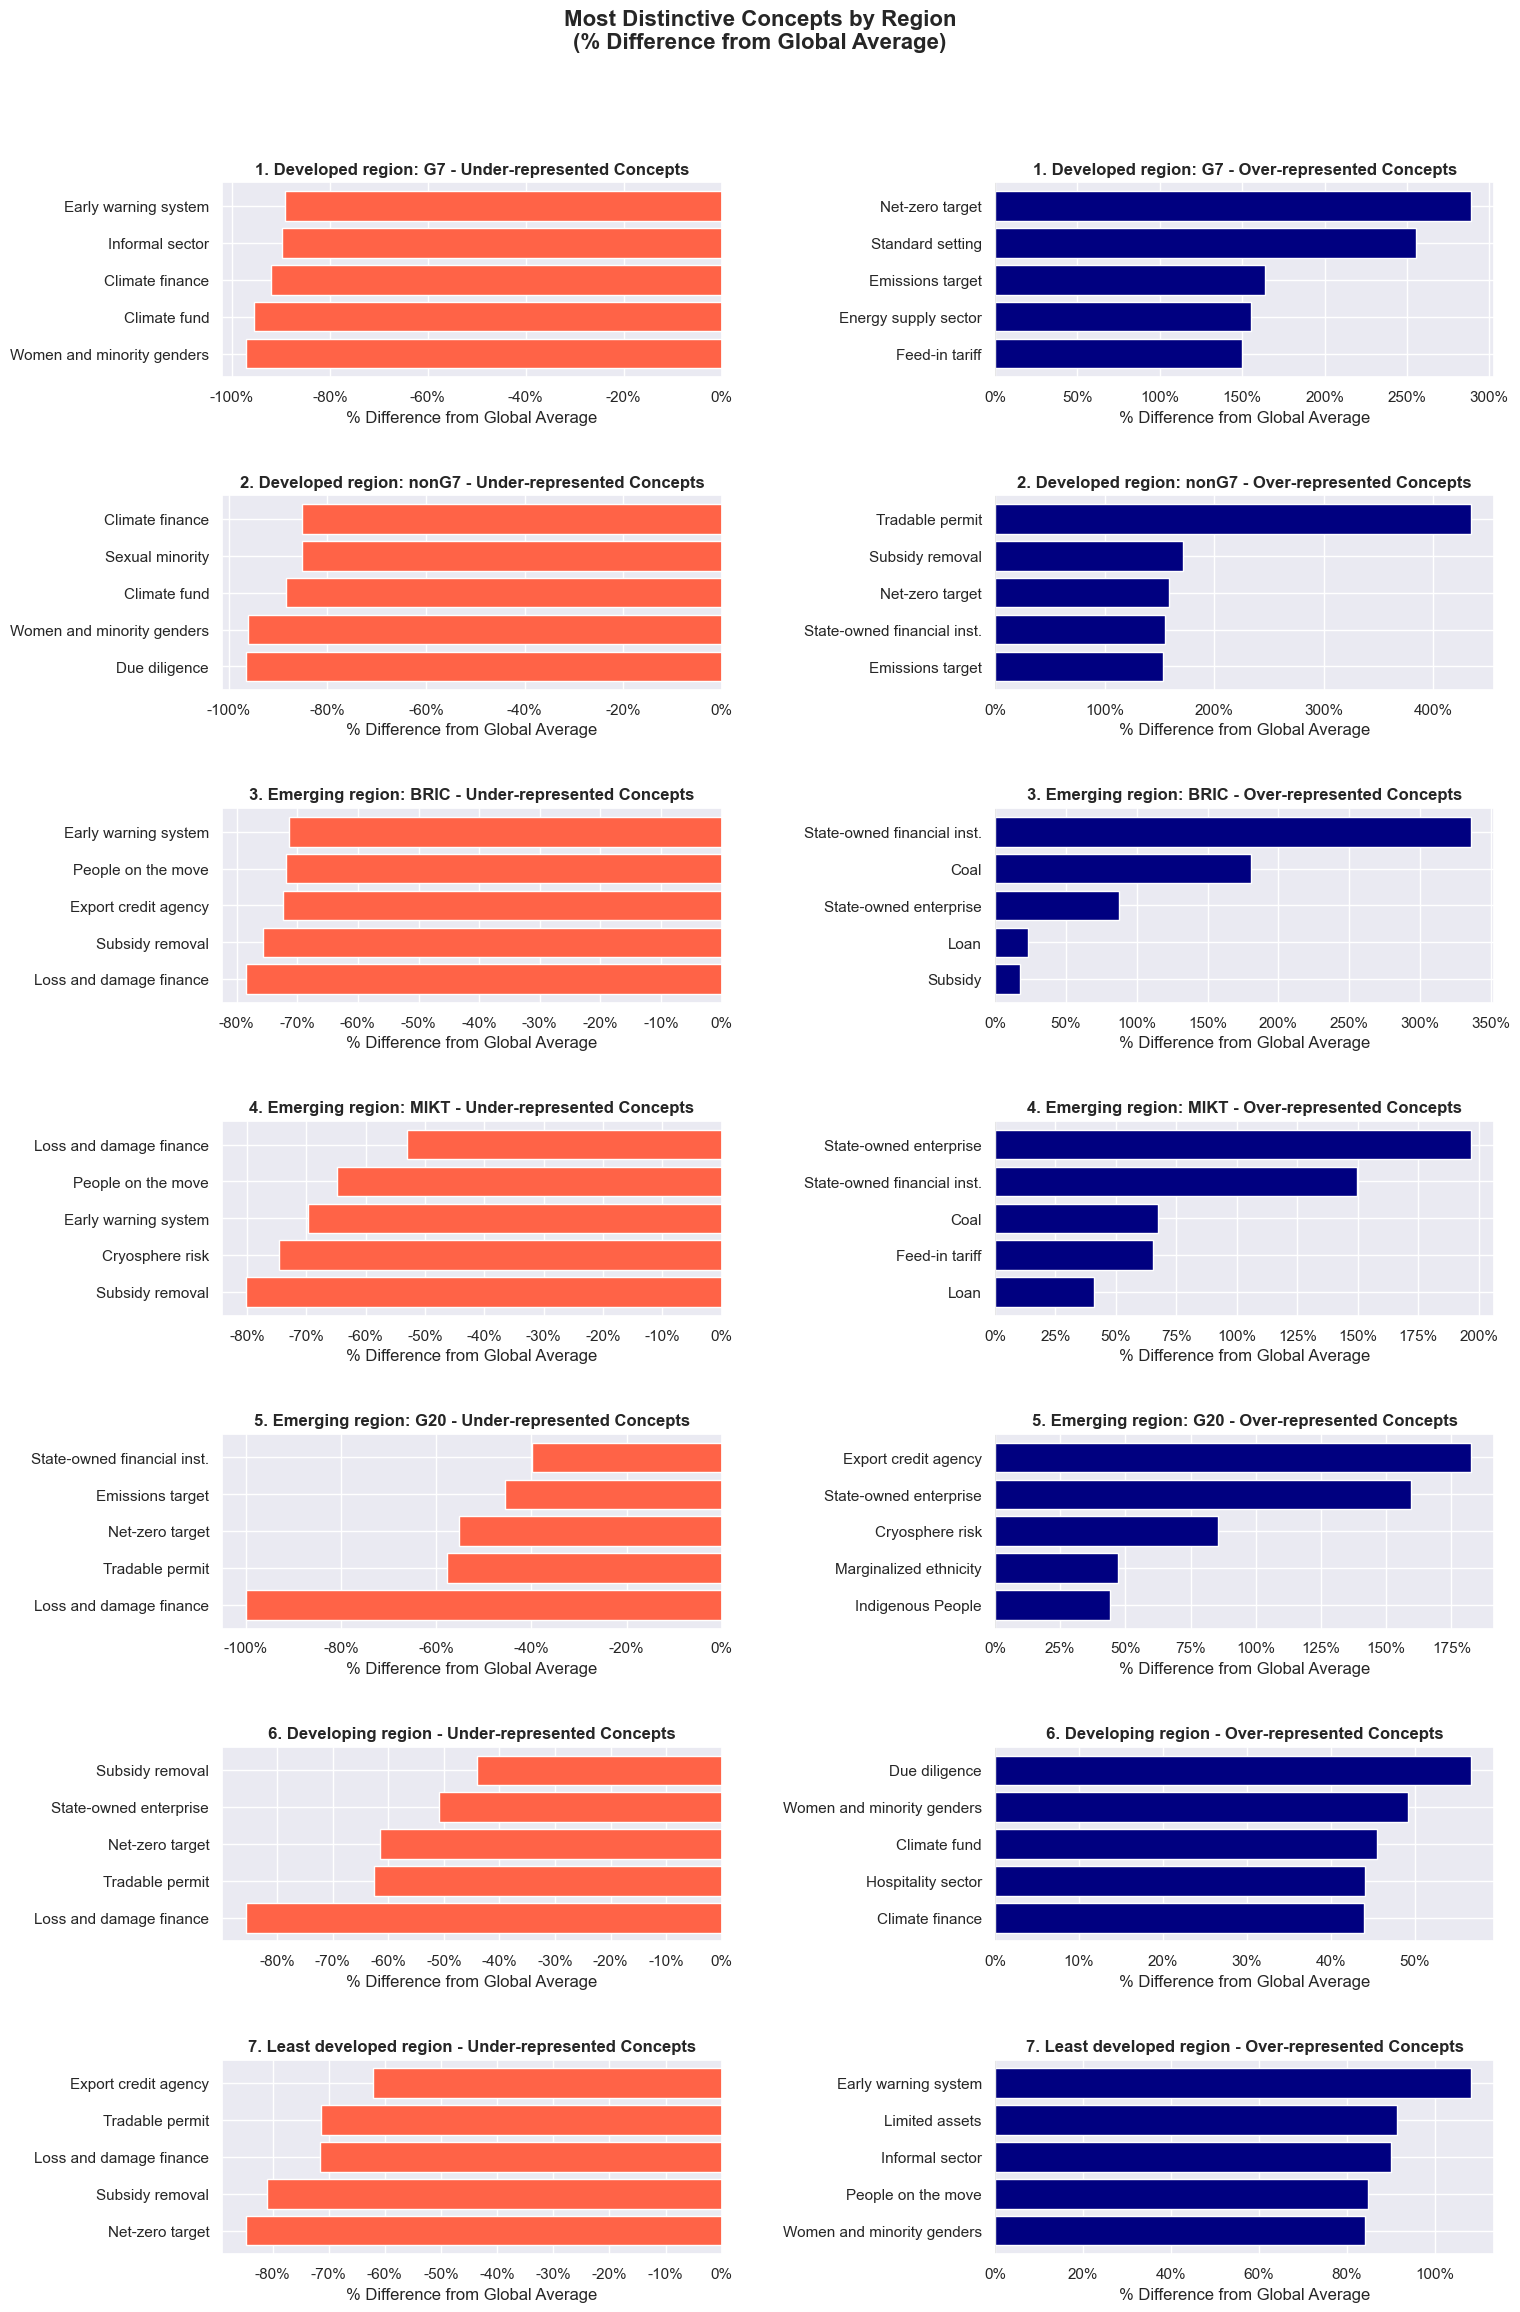

In [26]:
# And finally the economic categories, whih are subtely different
fig, axes = plot_region_concepts(merged_df_geographies, concept_cols, region_col='ECONOMY')

## Concept Co-occurrence Analysis

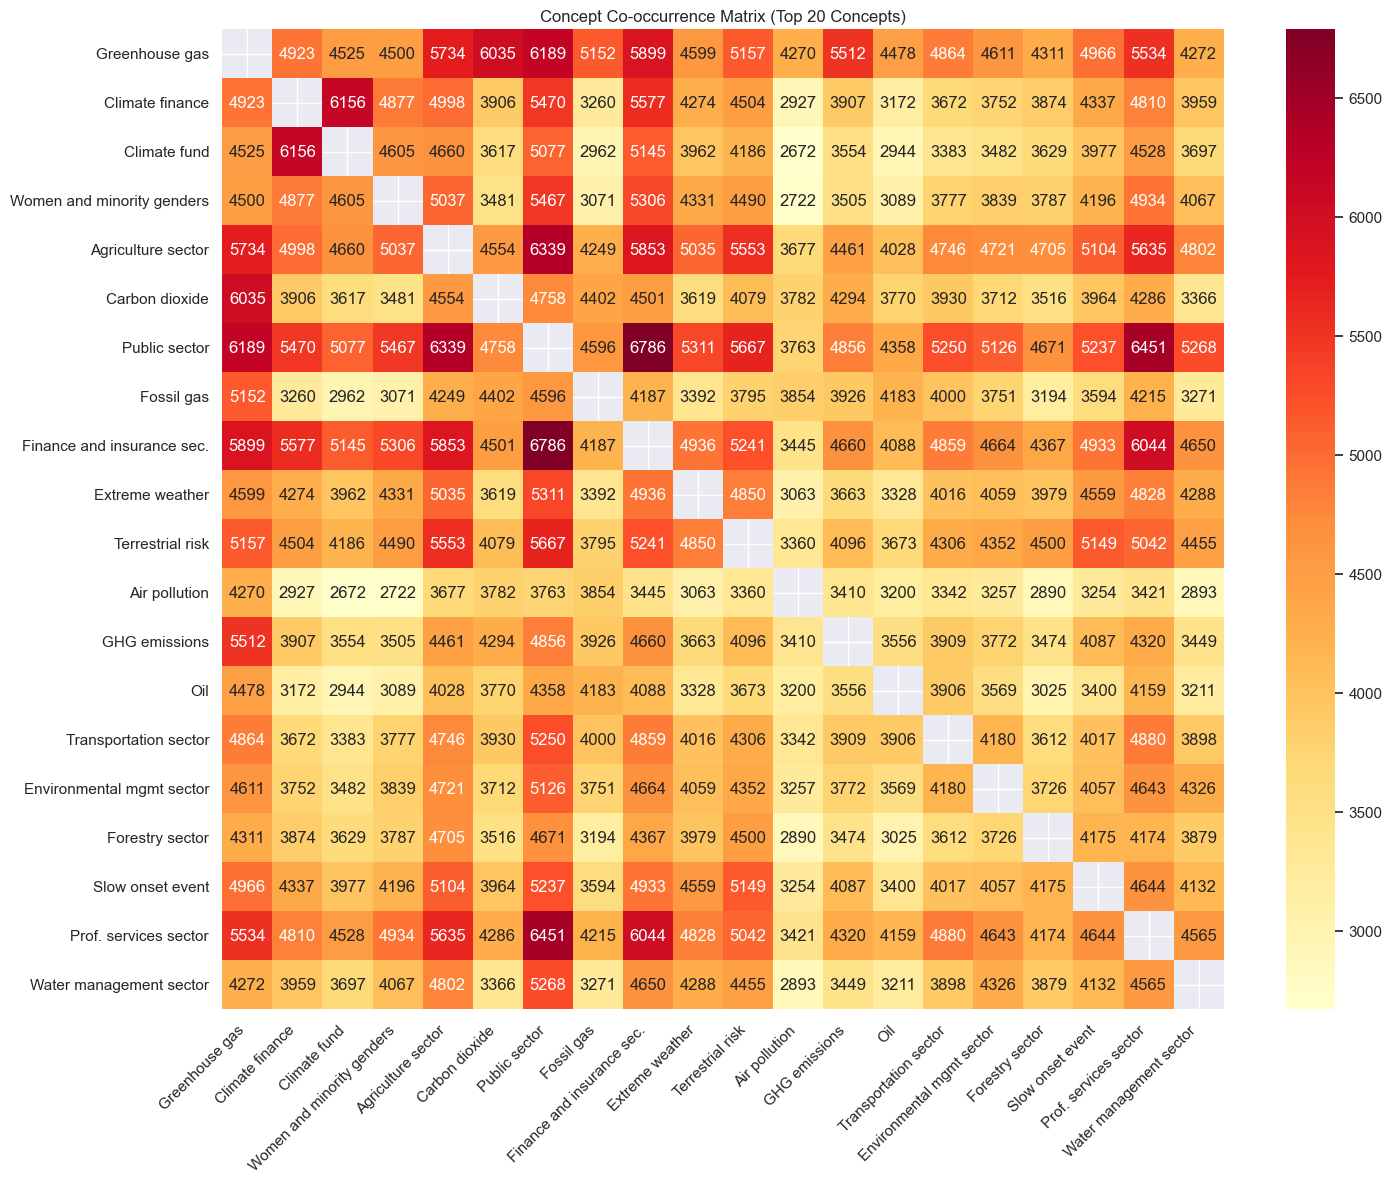

In [27]:
# Calculate co-occurrence matrix for top 20 concepts
top_20_concepts = concept_totals.head(20).index
cooccurrence = np.zeros((20, 20))

for i, concept1 in enumerate(top_20_concepts):
    for j, concept2 in enumerate(top_20_concepts):
        # Count documents where both concepts appear
        cooccurrence[i, j] = ((concept_counts[concept1] > 0) & 
                             (concept_counts[concept2] > 0)).sum()
        
# Set diagonal to np.nan to exclude from heatmap
np.fill_diagonal(cooccurrence, np.nan)

# Create co-occurrence heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(pd.DataFrame(cooccurrence, 
                        index=top_20_concepts,
                        columns=top_20_concepts),
            annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('Concept Co-occurrence Matrix (Top 20 Concepts)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

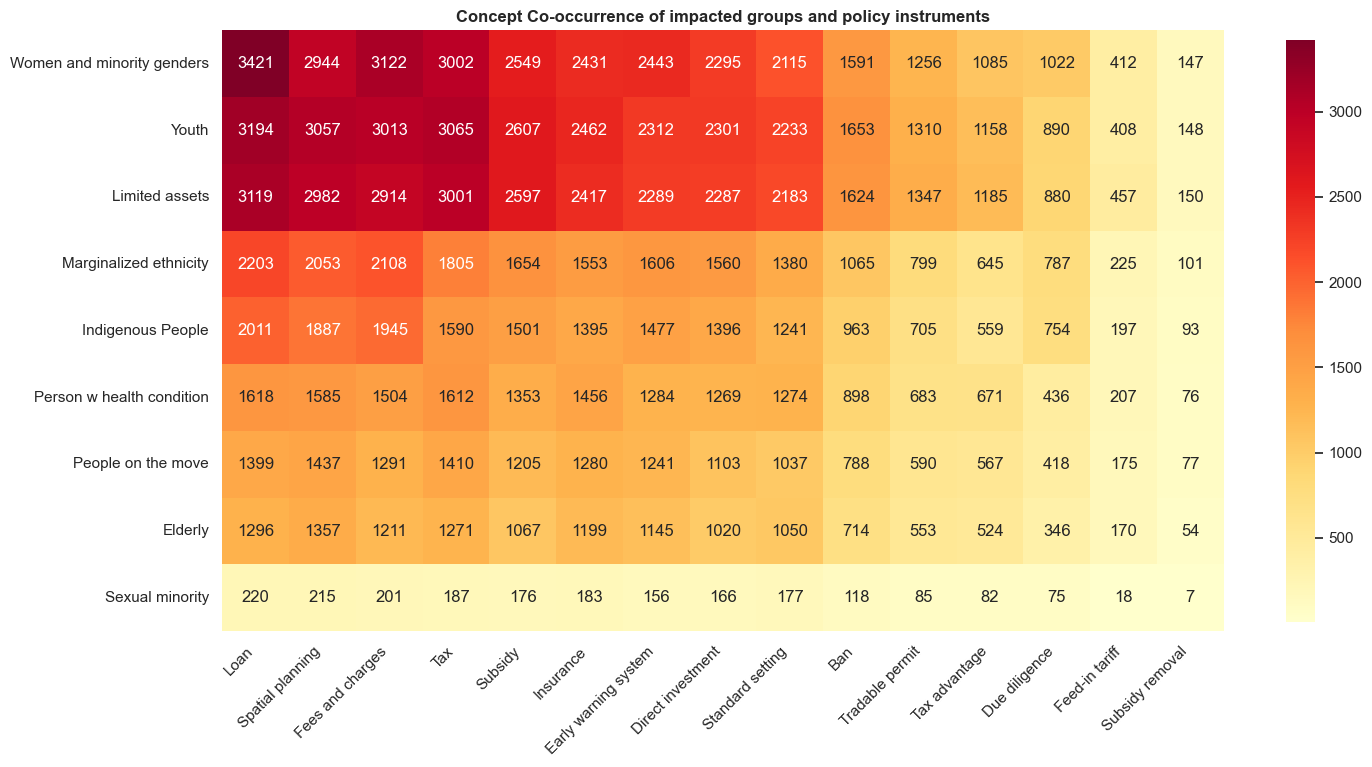

In [28]:
# Co-occurence with impacted groups on one axis and policy instruments on the other
impacted_groups = concept_categories['Impacted groups']
policy_instruments = concept_categories['Policy instruments']

# Create a co-occurrence matrix for impacted groups and policy instruments
impacted_policy_cooccurrence = np.zeros((len(impacted_groups), len(policy_instruments)))

for i, concept1 in enumerate(impacted_groups):
    for j, concept2 in enumerate(policy_instruments):
        # Count documents where both concepts appear
        impacted_policy_cooccurrence[i, j] = ((concept_counts[concept1] > 0) & 
                             (concept_counts[concept2] > 0)).sum()
        

df = pd.DataFrame(impacted_policy_cooccurrence, 
                        index=impacted_groups,
                        columns=policy_instruments)

#Calculate the most frequent impacted groups, then sort
most_frequent_impacted_groups = df.sum(axis=1).sort_values(ascending=False).index
df = df.loc[most_frequent_impacted_groups]
#Same for policy instruments
most_frequent_policy_instruments = df.sum().sort_values(ascending=False).index
df = df[most_frequent_policy_instruments]

# Create co-occurrence heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(df, square=True,
            annot=True, fmt='.0f', cmap='YlOrRd', cbar_kws={'shrink': 0.5})
plt.title('Concept Co-occurrence of impacted groups and policy instruments', weight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]),
 [Text(0.5, 0, 'Loan'),
  Text(1.5, 0, 'Spatial planning'),
  Text(2.5, 0, 'Fees and charges'),
  Text(3.5, 0, 'Tax'),
  Text(4.5, 0, 'Subsidy'),
  Text(5.5, 0, 'Insurance'),
  Text(6.5, 0, 'Early warning system'),
  Text(7.5, 0, 'Direct investment'),
  Text(8.5, 0, 'Standard setting'),
  Text(9.5, 0, 'Ban'),
  Text(10.5, 0, 'Tradable permit'),
  Text(11.5, 0, 'Tax advantage'),
  Text(12.5, 0, 'Due diligence'),
  Text(13.5, 0, 'Feed-in tariff'),
  Text(14.5, 0, 'Subsidy removal')])

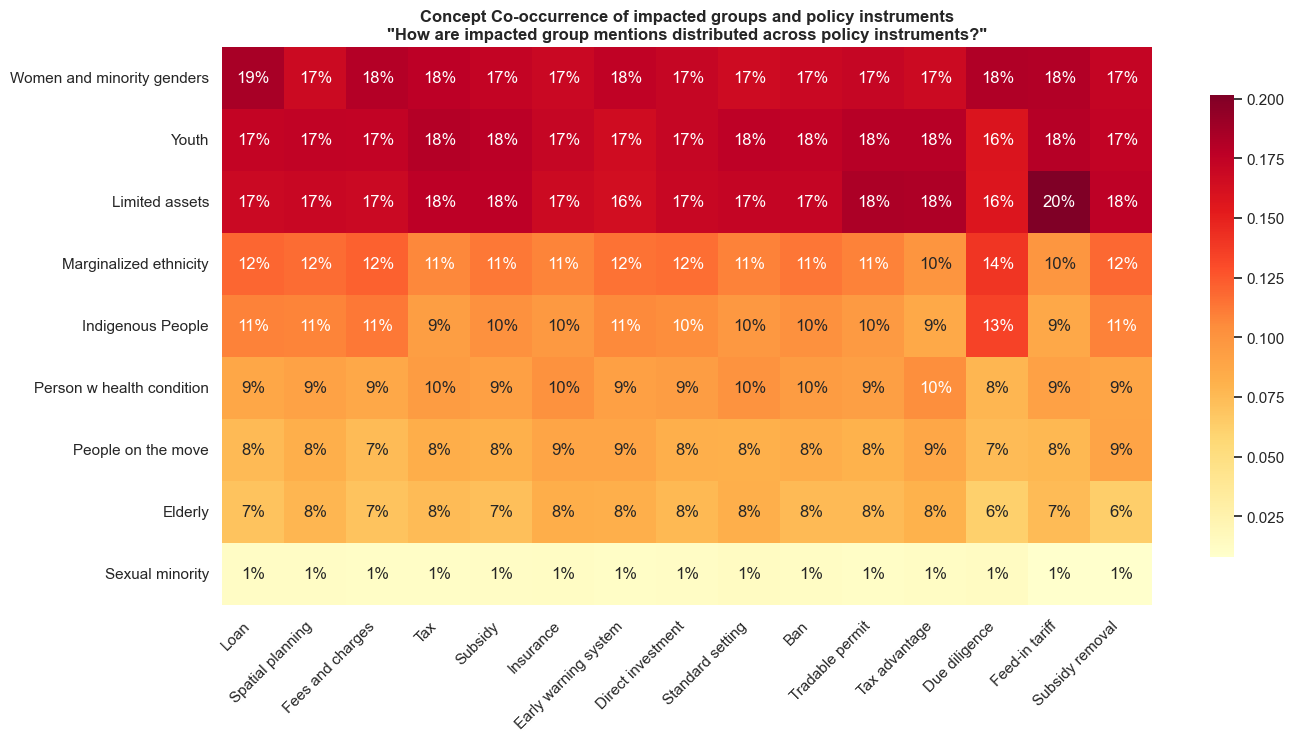

In [29]:
#Not as interesting as I hoped. Maybe the relative numbers are more interesting.
#Let's try that
df_row_relative = df.div(df.sum(axis=0), axis=1)
#Create a heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(df_row_relative, square=True,
            annot=True, fmt='.0%', cmap='YlOrRd', cbar_kws={'shrink': 0.5})
plt.title('Concept Co-occurrence of impacted groups and policy instruments\n"How are impacted group mentions distributed across policy instruments?"', weight='bold')
plt.xticks(rotation=45, ha='right')

## Temporal Analysis

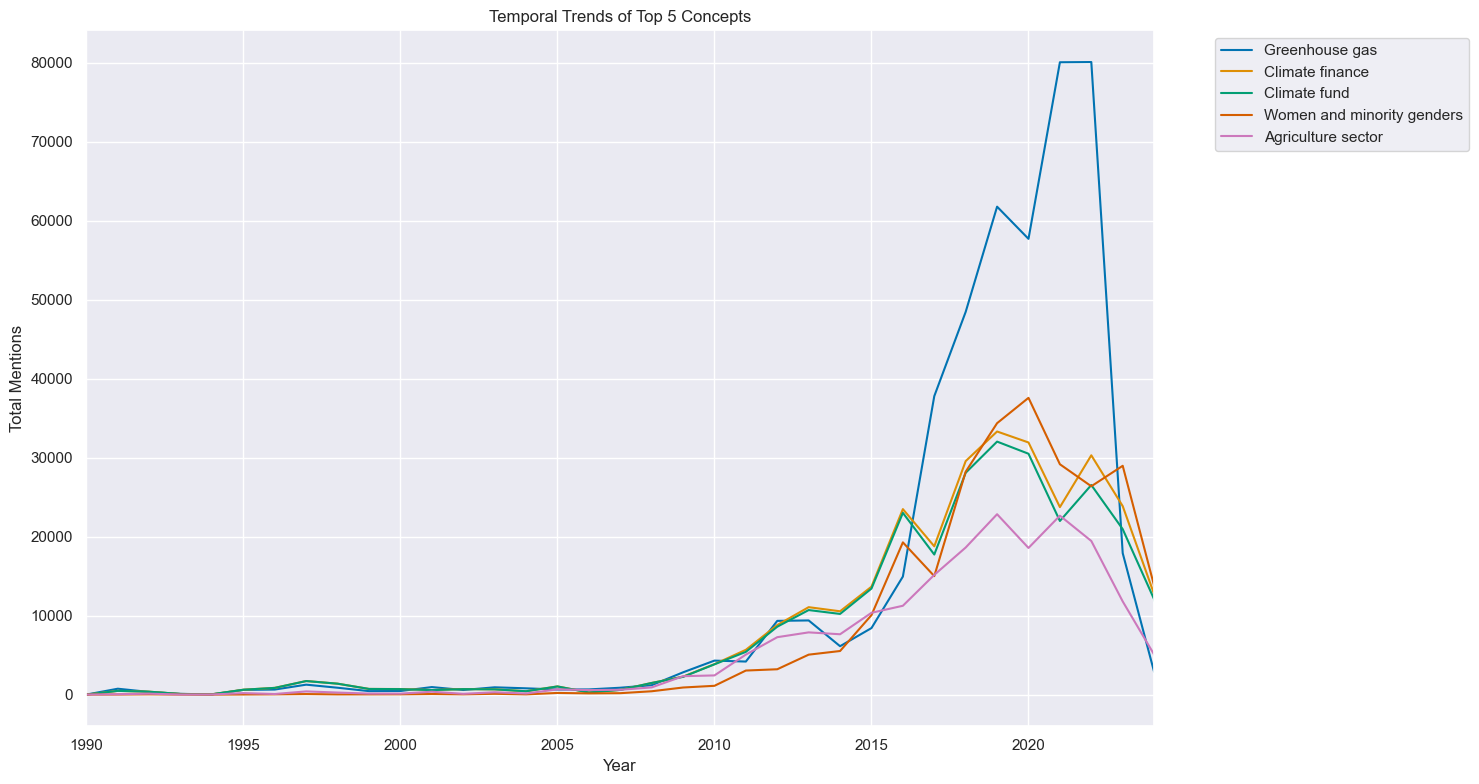

In [30]:
# Group by year and calculate concept trends
merged_df['year'] = pd.to_datetime(merged_df['document_metadata.publication_ts'], errors='coerce').dt.year
yearly_concepts = merged_df.groupby('year')[concept_cols].sum()

# Plot trends for top 5 concepts
top_5_concepts = concept_totals.head(5).index

plt.figure(figsize=(15, 8))
for concept in top_5_concepts:
    plt.plot(yearly_concepts.index, yearly_concepts[concept], label=concept)

plt.title('Temporal Trends of Top 5 Concepts')
plt.xlabel('Year')
plt.ylabel('Total Mentions')
plt.xlim(1990, 2024)
#plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [31]:
##To check that we're not dropping too many by coercing the date time
#df = doc_data.copy()
#df['parsed'] = pd.to_datetime(df['document_metadata.publication_ts'], errors='coerce')
# print(df.loc[df['parsed'].isna(), 'document_metadata.slug'].unique())
#df.loc[df['parsed'].isna(), 'document_id'].value_counts()


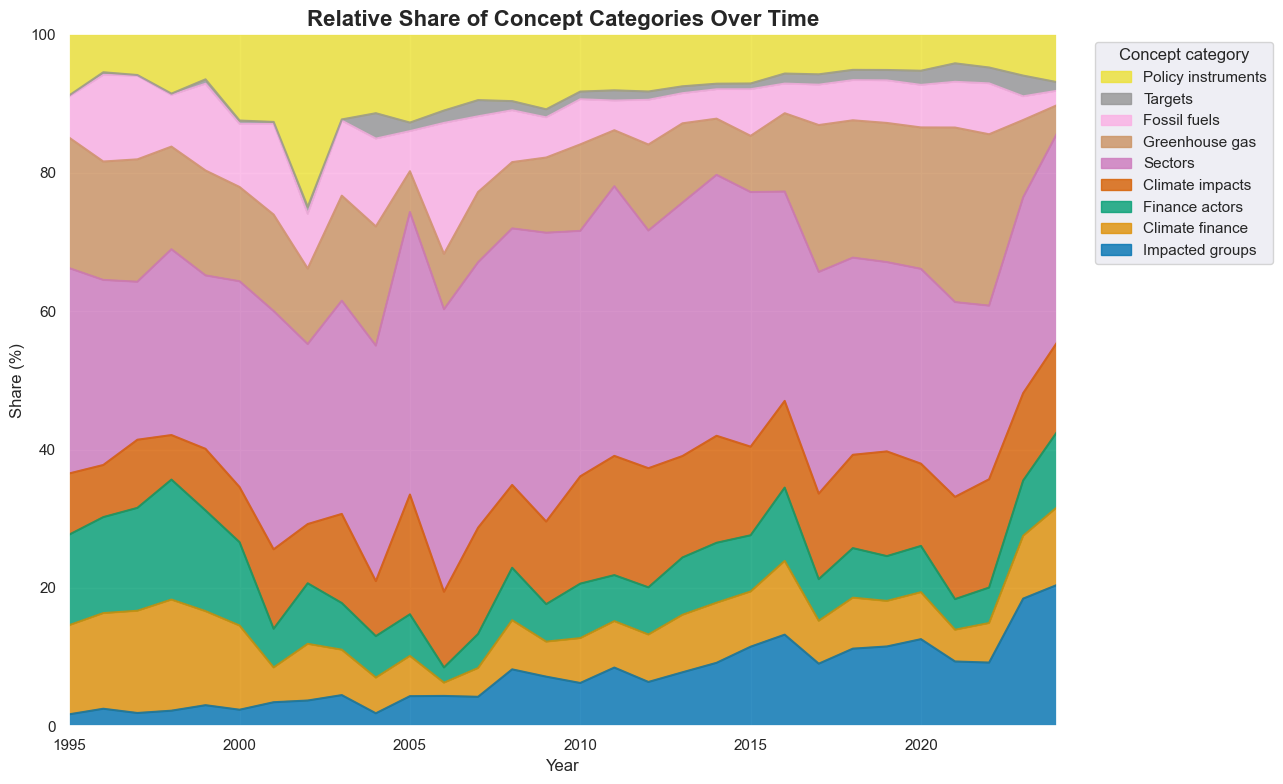

In [32]:
print_exact = False

# Create a new dataframe with yearly category sums
yearly_category_sums = pd.DataFrame()

# For each category, sum up the concepts in that category
for category, concepts in concept_categories.items():
    # Get columns that match the concepts in this category
    category_cols = [col for col in concept_cols if col in concepts]
    # Sum these columns for each year
    yearly_category_sums[category] = merged_df.groupby('year')[category_cols].sum().sum(axis=1)

# Calculate relative shares (percentages)
yearly_category_shares = yearly_category_sums.div(yearly_category_sums.sum(axis=1), axis=0) * 100

# Create the plot
ax = yearly_category_shares.plot(kind='area', stacked=True, alpha=0.8,
                                 figsize=(13,8))
plt.title('Relative Share of Concept Categories Over Time', weight='bold', size = 16)
plt.xlabel('Year')
plt.xlim(1995, 2024) #Data on the far sides is not complete/reliable
plt.ylabel('Share (%)')
plt.ylim(0, 100)
#By default, the legend is in inverse order of the categories, so lets reverse
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Concept category', loc='upper left', bbox_to_anchor=(1.03, 1))

plt.tight_layout()
plt.show()

if print_exact:
    # Print some summary statistics
    print("\nSummary Statistics:")
    print("\nAverage share per category:")
    print(yearly_category_shares.mean().round(2))

    print("\nMaximum share per category:")
    print(yearly_category_shares.max().round(2))

    print("\nMinimum share per category:")
    print(yearly_category_shares.min().round(2))

Early data is probably not very reliable, but should be getting OK from around 2000 onwards.
Possibly a peak due to the Kyoto Protocol entering into force? Worth investigating the policy instruments over time. 
Impacted groups clearly on the rise. Targets remain small, but also coming up. 
The enormous over-representation of the  "Sectors" and "Greenhouse gas" categories is due to mandatory reporting requirements which is making this hard to see.

<Figure size 1500x800 with 0 Axes>

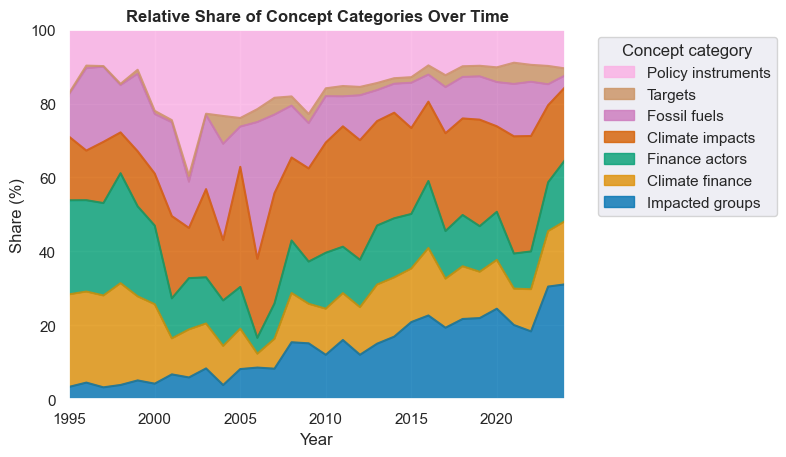

In [33]:
#Let's try the same without those two categories
# Create a new dataframe with yearly category sums
yearly_category_sums_no_sectors_ghg = pd.DataFrame()

# For each category, sum up the concepts in that category
for category, concepts in concept_categories.items():
    if category not in ["Sectors", "Greenhouse gas"]:
        # Get columns that match the concepts in this category
        category_cols = [col for col in concept_cols if col in concepts]
        # Sum these columns for each year
        yearly_category_sums_no_sectors_ghg[category] = merged_df.groupby('year')[category_cols].sum().sum(axis=1)

# Calculate relative shares (percentages)
yearly_category_shares_no_sectors_ghg = yearly_category_sums_no_sectors_ghg.div(yearly_category_sums_no_sectors_ghg.sum(axis=1), axis=0) * 100

# Create the plot
fig = plt.figure(figsize=(15, 8))
ax = yearly_category_shares_no_sectors_ghg.plot(kind='area', stacked=True, alpha=0.80)
plt.title('Relative Share of Concept Categories Over Time', weight='bold')
plt.xlabel('Year')
plt.xlim(1995, 2024) #Data on the far sides is not complete/reliable
plt.ylim(0, 100)
plt.ylabel('Share (%)')

#By default, the legend is in inverse order of the categories
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Concept category', loc='upper left', bbox_to_anchor=(1.05, 1))


fig.tight_layout()
plt.show()

## Temporal analysis of  categories
This is interesting but somewhat deceptive. 
For one thing, the categories are not all developed to the same level of detail, so some of the relative differences are in practice meaningless.
For another, it somewhat implies that we are giving an overview of all things that are discussed (as it sums to 100).
Probably, a more instructive view is to create number of graphs, looking at individual topics per topic group. To make this easy, let's create a function and then just churn through them.

In [34]:
def plot_topic_shares_over_time(topic_list, merged_df, title='Relative Share of Topics Over Time', 
                                print_exact=False, sort_by_frequency=True):
    """
    Create a stacked area plot showing relative shares of individual topics over time.
    
    Args:
        topic_list (list): List of topic names to analyze
        merged_df (DataFrame): DataFrame containing the data
        title (str, optional): Title for the plot
        print_exact (bool, optional): Whether to print exact statistics
        sort_by_frequency (bool, optional): Whether to sort the topics by frequency (highest on top)
    """
    # Create a new dataframe with yearly topic sums
    yearly_topic_sums = pd.DataFrame()
    
    # For each topic, sum up its mentions
    for topic in topic_list:
        yearly_topic_sums[topic] = merged_df.groupby('year')[topic].sum()
    
    # Calculate relative shares of all in that year (percentages)
    yearly_topic_shares = yearly_topic_sums.div(yearly_topic_sums.sum(axis=1), axis=0) * 100

    if sort_by_frequency:
        most_frequent_topics = yearly_topic_sums.sum().sort_values(ascending=True).index
        yearly_topic_shares = yearly_topic_shares[most_frequent_topics]
    
    # Create the stacked area plot
    ax = yearly_topic_shares.plot(kind='area', stacked=True, alpha=0.8,
                                  figsize=(13, 8))
    plt.title(title, weight='bold', size = 16)
    plt.xlabel('Year')
    plt.xlim(2000, 2024)
    plt.ylabel('Share (%)')
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.5)

    #By default, the legend is in inverse order of the categories
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], title='Concept', loc='upper left', bbox_to_anchor=(1.03, 1))

    plt.tight_layout()
    plt.show()
    if print_exact:
        # Print summary statistics
        print("\nSummary Statistics:")
        print("\nAverage share per topic:")
        print(yearly_topic_shares.mean().round(2))
        
        print("\nMaximum share per topic:")
        print(yearly_topic_shares.max().round(2))
        
        print("\nMinimum share per topic:")
        print(yearly_topic_shares.min().round(2))

    return(fig, ax)



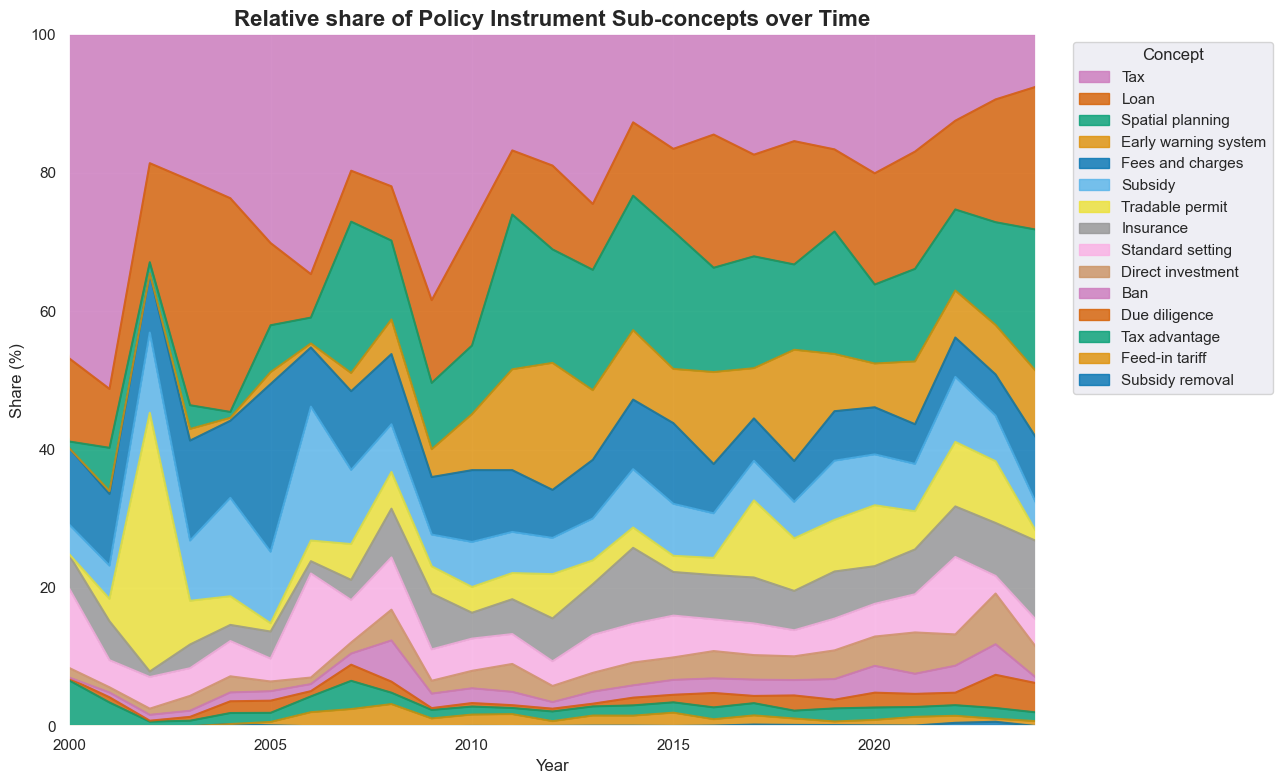

In [35]:
#For policy instruments, we can probably just use the concept_categories dictionary
fig, ax = plot_topic_shares_over_time(concept_categories['Policy instruments'], merged_df,
                                      title = 'Relative share of Policy Instrument Sub-concepts over Time')

The spike in tradable permits around Kyoto is very noticable so that roughly holds up. Not so much the first phase of the EU ETS though.
Early warning systems come up around 2010
Insurance is increasing steadily

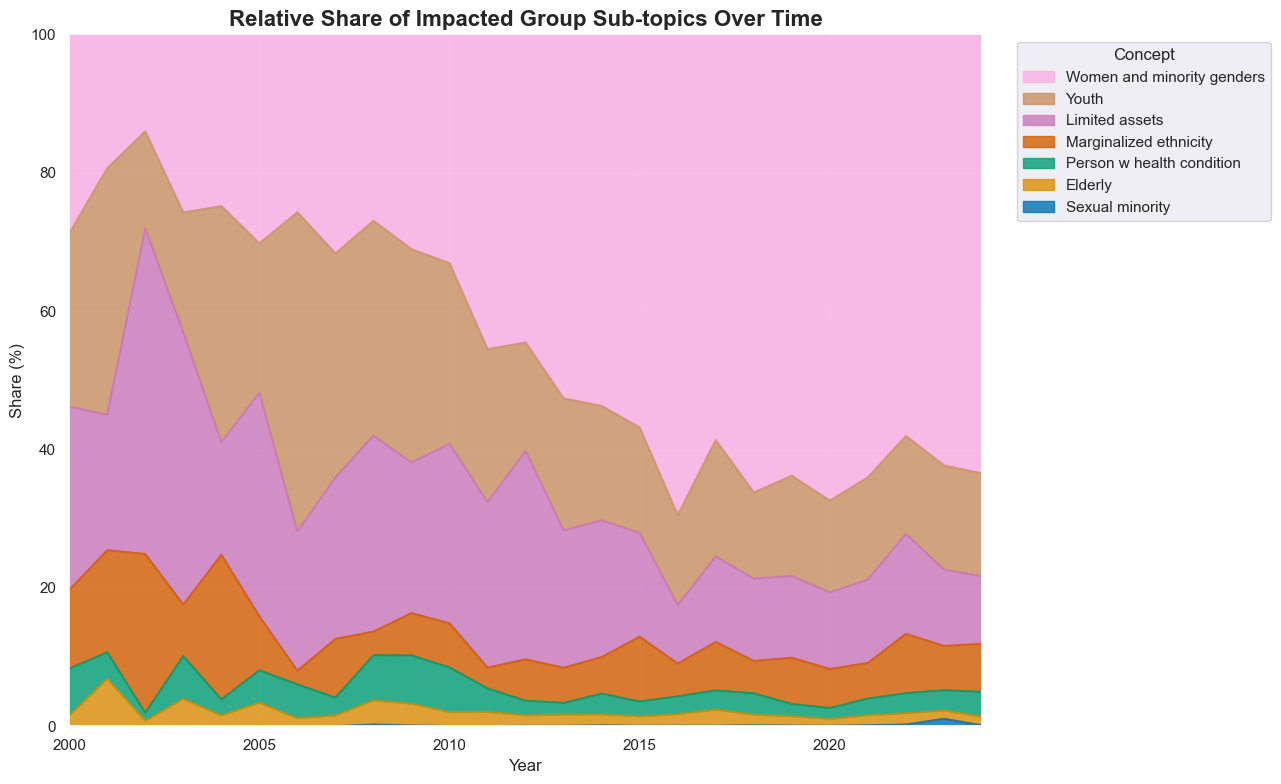

In [36]:
#Now let's try impacted groups
#Here we have some dual parent relationships at lower levels-- to avoid double counting, let's leave those out
impacted_to_plot = ['Sexual minority',
                    'Limited assets',
                    'Marginalized ethnicity',
                    'Person w health condition',
                    'Youth',
                    'Women and minority genders',
                    'Elderly',   
                    ]

fig, ax = plot_topic_shares_over_time(impacted_to_plot, merged_df, title='Relative Share of Impacted Group Sub-topics Over Time')


Striking. I strongly suspect the rise of women is in no small part due to the (fairly recent) documents from Multilateral climate funds

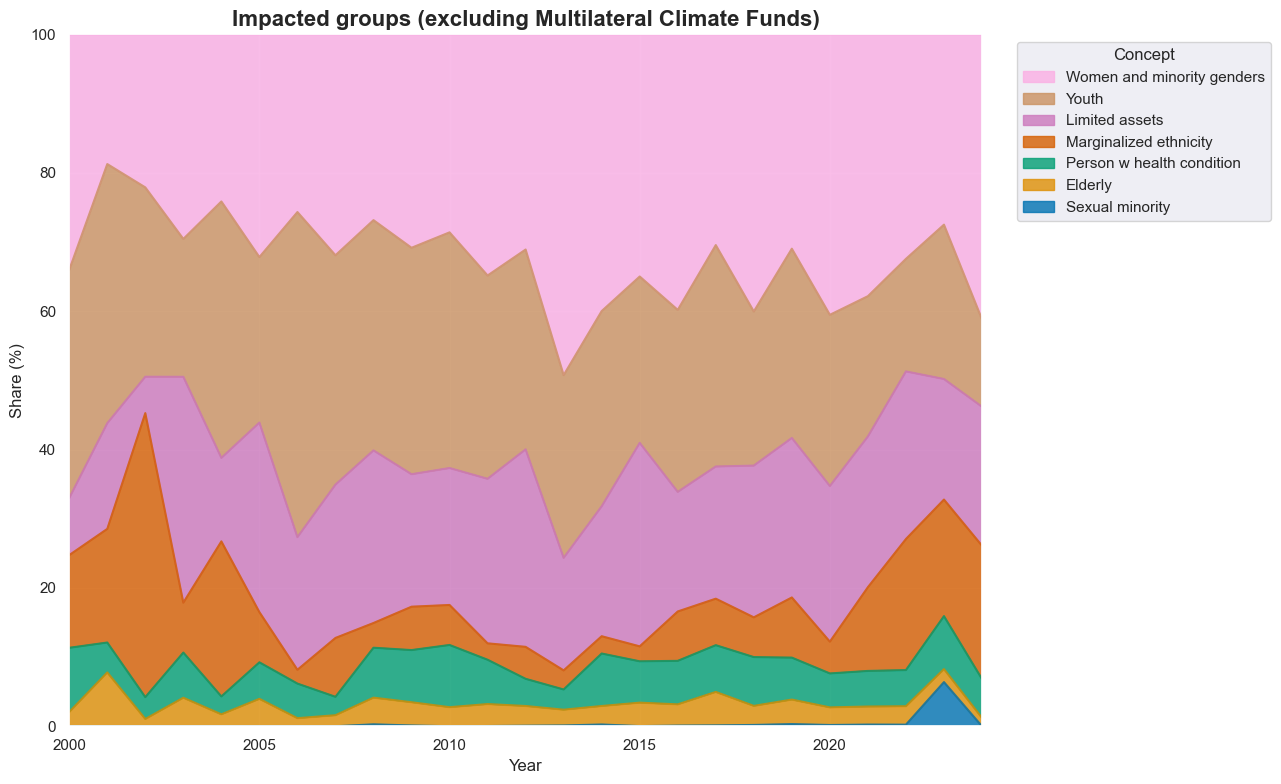

In [37]:
#Let's try excluding the Multilateral Climate Funds
fig, ax = plot_topic_shares_over_time(impacted_to_plot,
                                      merged_df[~merged_df['document_id'].str.startswith(('GEF', 'GCF', 'AF', 'CIF'))],
                                      title='Impacted groups (excluding Multilateral Climate Funds)')




Index(['Agriculture sector', 'Public sector', 'Finance and insurance sec.',
       'Transportation sector', 'Environmental mgmt sector', 'Forestry sector',
       'Prof. services sector', 'Water management sector', 'Education sector',
       'Energy supply sector'],
      dtype='object')


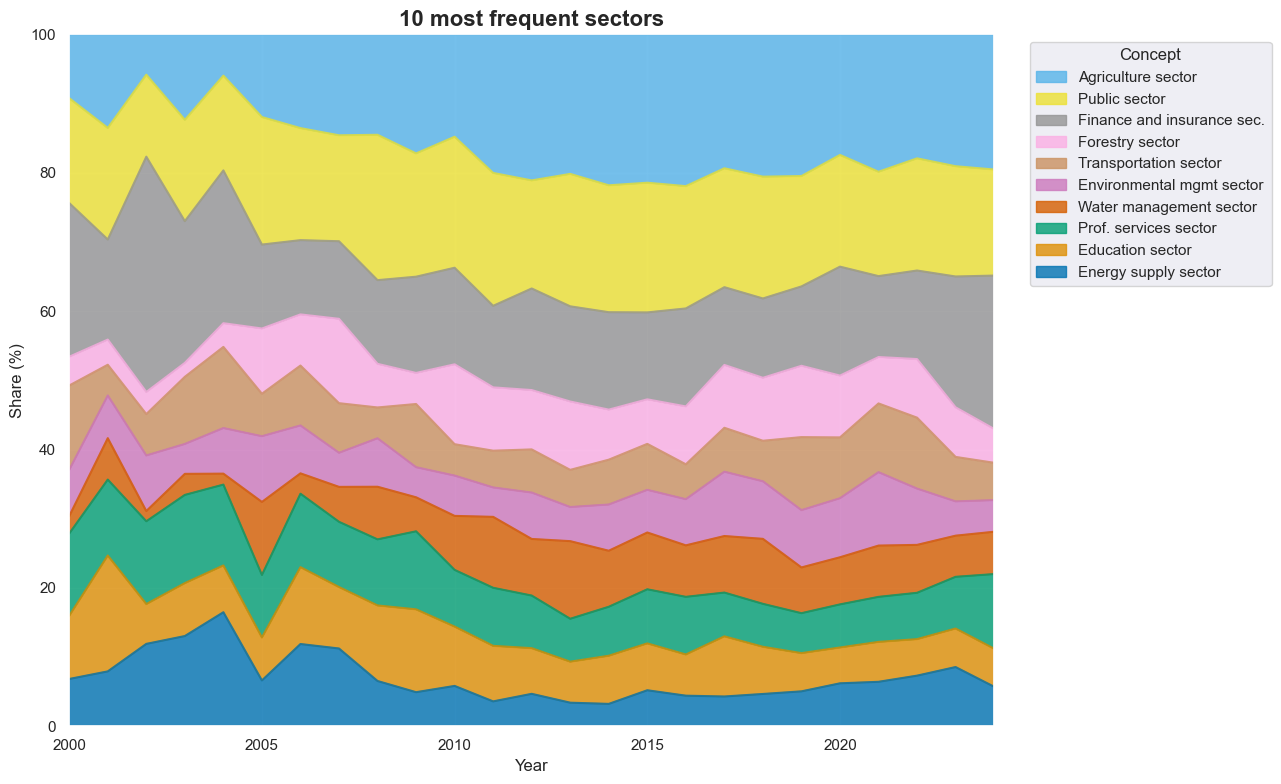

In [38]:
#For sectors, we have a lot of categories, so let's just look at the most frequent ones
most_frequent_sectors = merged_df[concept_categories['Sectors']].sum().sort_values(ascending=False).index[:10]
print(most_frequent_sectors)
fig, ax = plot_topic_shares_over_time(most_frequent_sectors, merged_df,
                                      title='10 most frequent sectors')





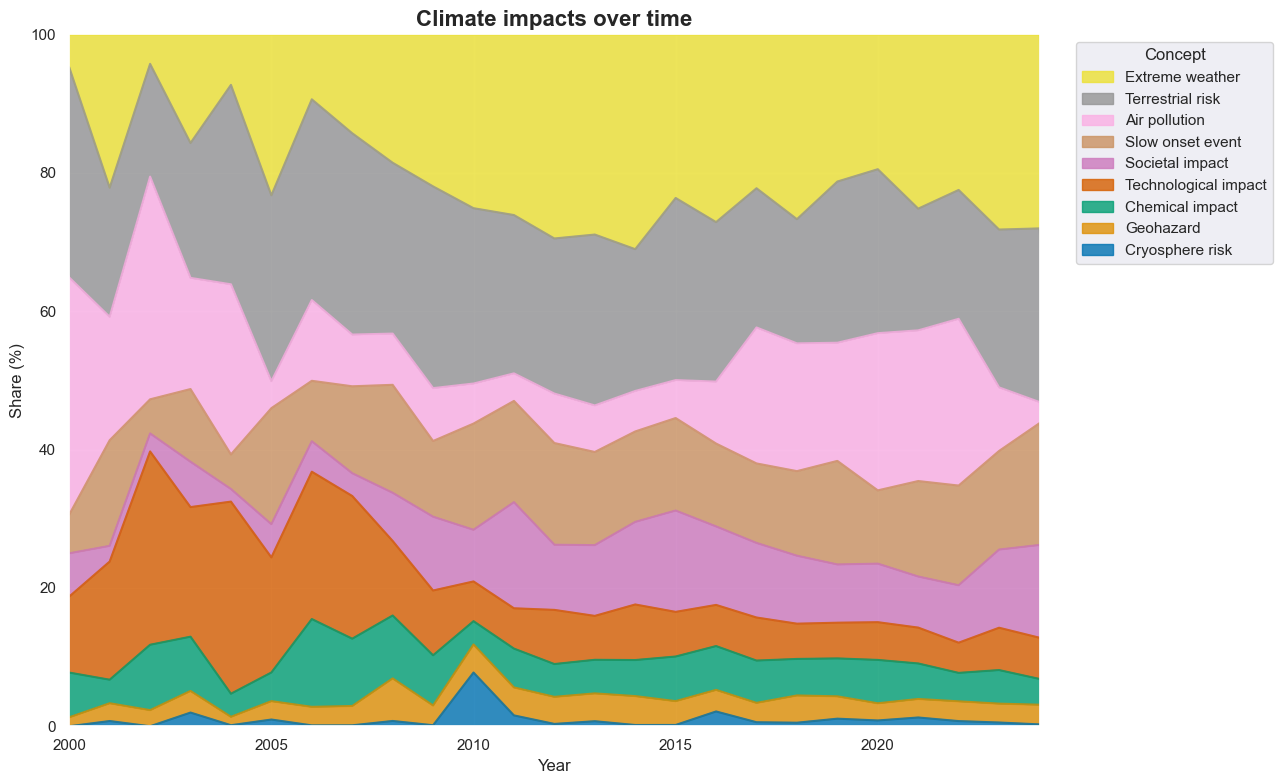

In [39]:
fig, ax = plot_topic_shares_over_time(concept_categories['Climate impacts'], merged_df,
                                      title='Climate impacts over time')



## Corpus types
We know the corpus type is pretty unevenly spread geographically; from the gender example above, it seems pretty clear it also influences the content. 

In [40]:
#First, let's just see how many passages with concepts there are for each corpus type
merged_df['document_metadata.corpus_type_name'].value_counts()

document_metadata.corpus_type_name
Laws and Policies    3629
Intl. agreements     1698
GEF                  1404
GCF                  1174
AF                    539
Reports               488
CIF                   209
Name: count, dtype: int64

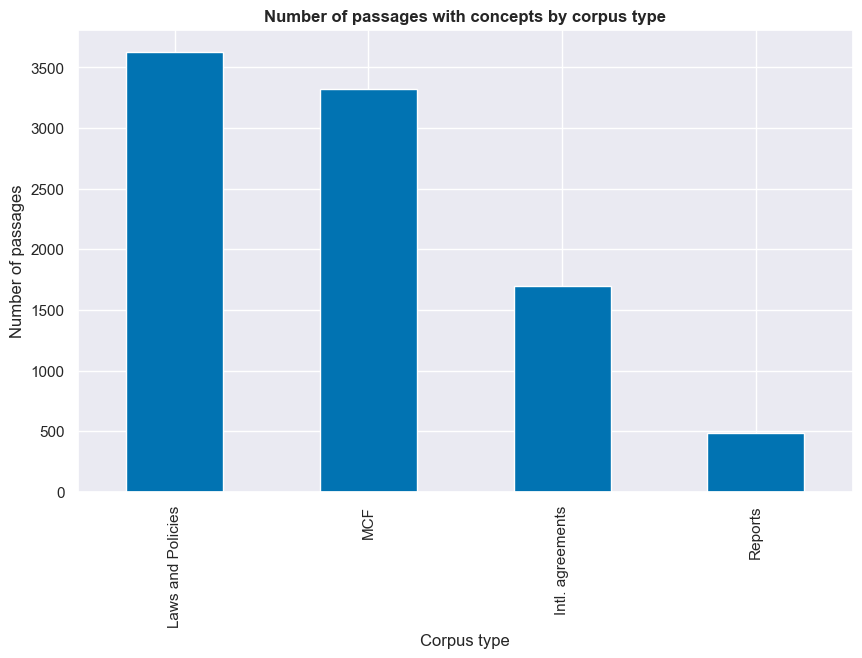

In [41]:
#To make things easier for ourselves, let's merge the MCF ones
merged_df['corpus'] = merged_df['document_metadata.corpus_type_name'].replace({'GEF': 'MCF', 
                                                                               'GCF': 'MCF', 
                                                                               'AF': 'MCF', 
                                                                               'CIF': 'MCF'})
#Now plot this as bars
fig, ax = plt.subplots(figsize=(10, 6))
merged_df['corpus'].value_counts().plot(kind='bar', ax=ax)
ax.set_title('Number of passages with concepts by corpus type', weight='bold')
ax.set_xlabel('Corpus type')
ax.set_ylabel('Number of passages')
plt.show()

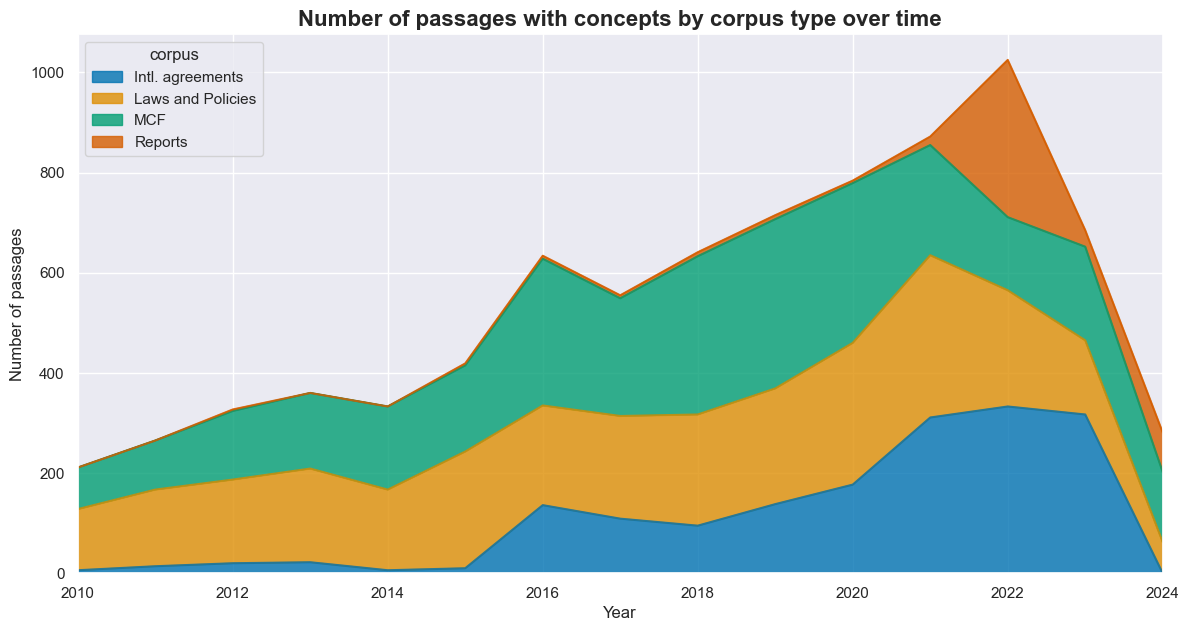

In [42]:
#Let's see how that changed over time
#Let's plot the yearly counts as a stacked line plot
ax = merged_df.groupby(['year', 'corpus']).size().unstack().plot(kind='area', stacked=True, alpha=0.8,
                                                                 figsize=(14,7))
ax.set_title('Number of passages with concepts by corpus type over time', weight='bold', size = 16)
ax.set_xlabel('Year')
ax.set_ylabel('Number of passages')
ax.set_xlim(2010, 2024)
plt.show()

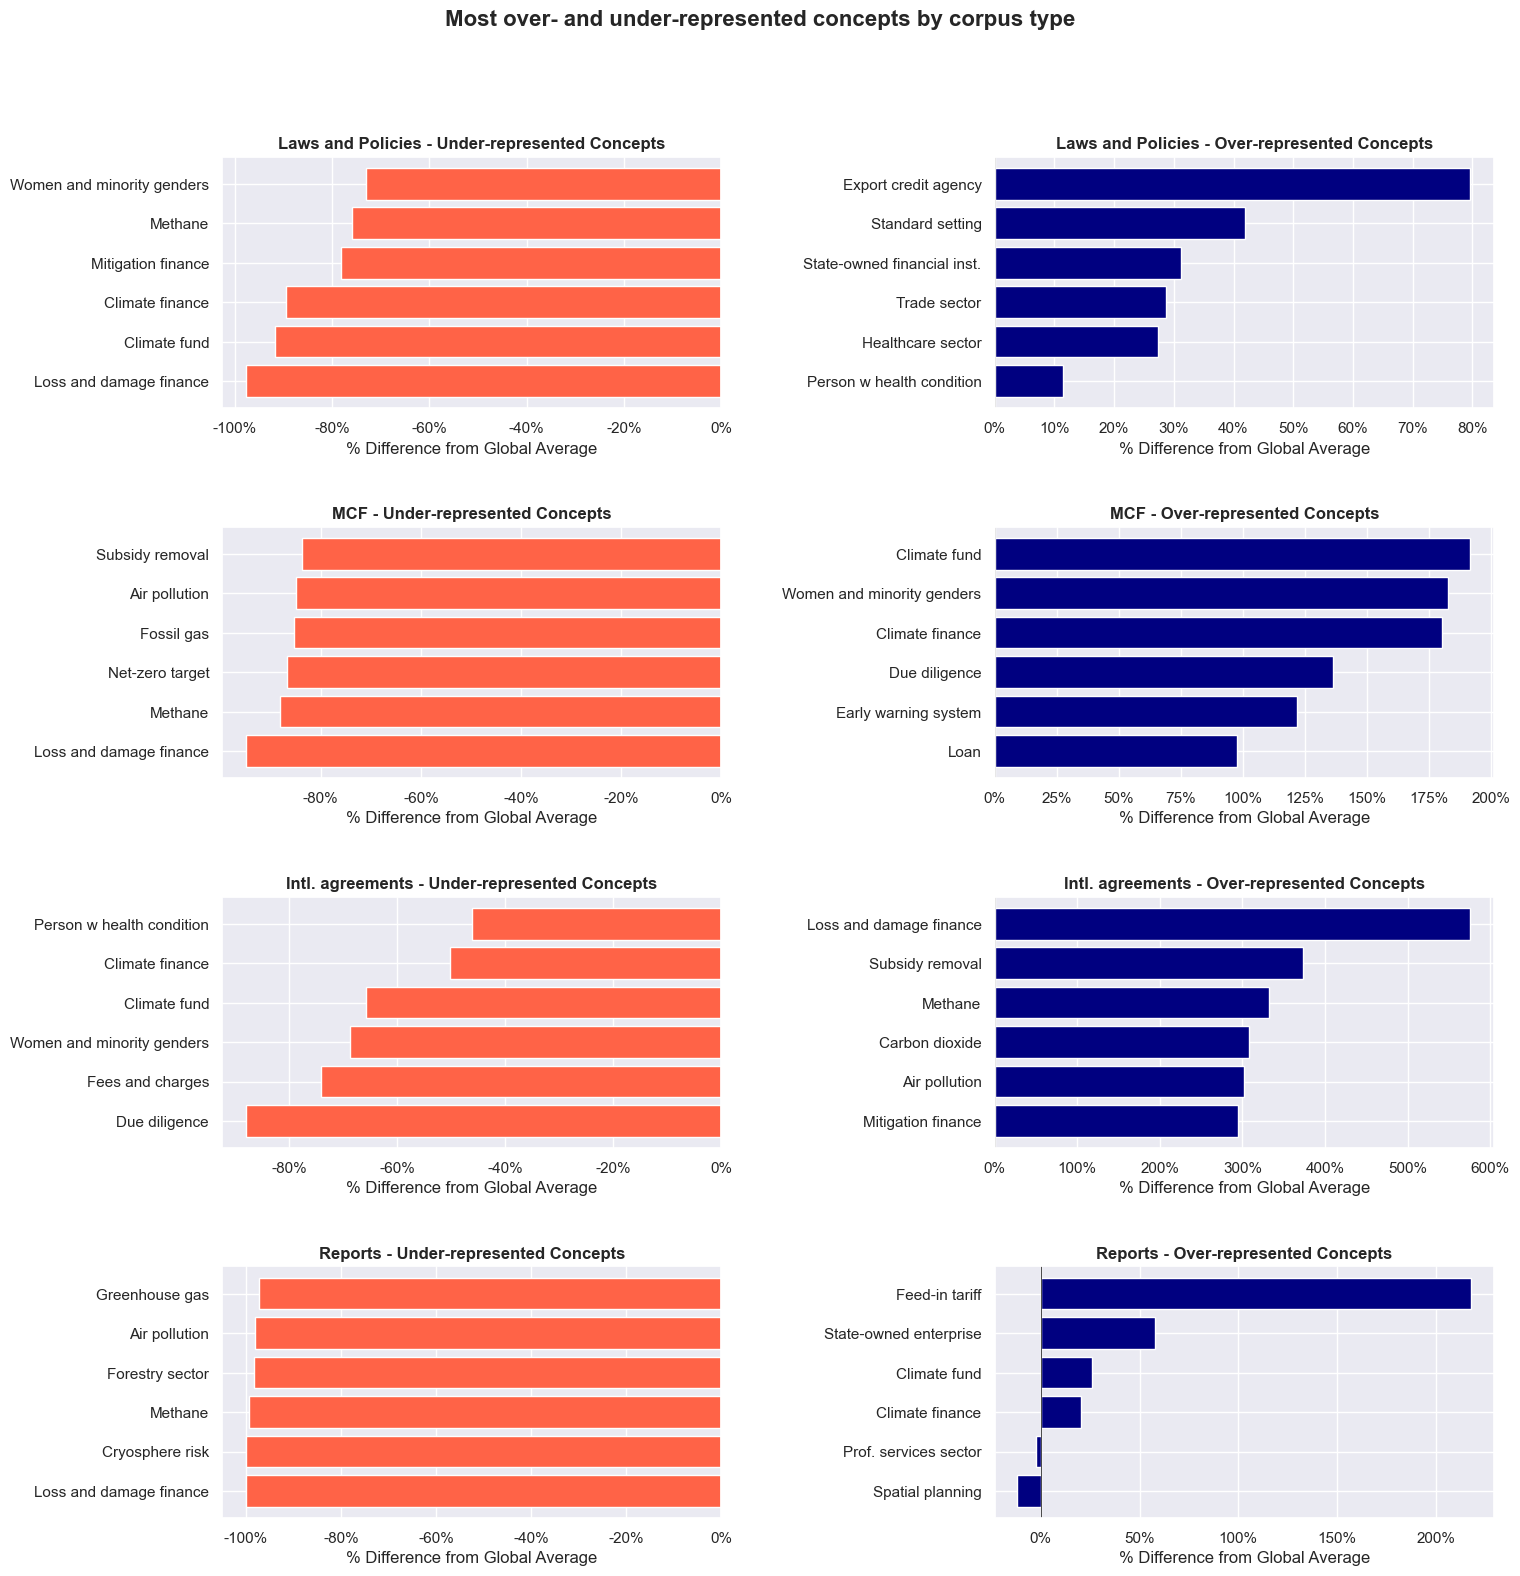

In [43]:
#Plot the most overrepresented concepts by corpus type
#We can abuse the region function to do this
fig, ax = plot_region_concepts(merged_df, concept_cols, region_col='corpus',
                               title='Most over- and under-represented concepts by corpus type',
                               custom_region_order= ['Laws and Policies', 'MCF','Intl. agreements', 'Reports'],
                               n=6)



